# Imports

In [1]:
import numpy as np
import tensorflow as tf
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, f1_score, fbeta_score, accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
import optuna
import os
import random
from mamba_ssm import Mamba2
from sklearn.preprocessing import StandardScaler, RobustScaler
import pandas as pd
import json

2025-10-08 19:35:26.666601: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/usr/local/lib/python3.11/dist-packages/google/protobuf/runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/attr_value.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/google/protobuf/runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/tensor.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
/usr

# Controle do uso da GPU

In [2]:
if torch.cuda.is_available():    
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
   
print("\n\nCHECKING FOR TENSORFLOW")
print(tf.config.list_physical_devices('GPU'))

gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"--- Usando dispositivo: {DEVICE} ---")

There are 1 GPU(s) available.
We will use the GPU: NVIDIA GeForce RTX 4080


CHECKING FOR TENSORFLOW
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
1 Physical GPUs, 1 Logical GPUs
--- Usando dispositivo: cuda ---


I0000 00:00:1759952130.520803     478 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13912 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4080, pci bus id: 0000:0b:00.0, compute capability: 8.9


# Fixing parameters to prevent random results

In [3]:
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Defining Datasets

In [4]:
EXPERIMENTS_CONFIG = [
    {
        "name": "Cap 51",
        "csv_file": "cap51processed.csv",
        "train_start_index": 0,
        "train_end_index": 2934,
        "anomaly_start_index": 5632,
        "optuna_trials": 100,
        "z_scores_to_test": [12.5, 15.0, 20.0, 25.0, 30.0, 35.0, 40.0, 45.0, 50.0, 55.0, 60.0, 70.0]
    },
    {
        "name": "Cap 52",
        "csv_file": "cap52processed.csv",
        "train_start_index": 0,
        "train_end_index": 324,
        "anomaly_start_index": 778,
        "optuna_trials": 200,
        "z_scores_to_test": [70.0, 75.0, 80.0, 85.0, 90.0, 95.0, 100.0, 110.0, 120.0, 125.0, 130.0, 140.0, 150.0, 160.0]
    },
    {
        "name": "Mentored",
        "csv_file": "mentored.csv",
        "train_start_index": 0,
        "train_end_index": 1840,
        "anomaly_start_index": 3601,
        "optuna_trials": 100,
        "z_scores_to_test": [3.0, 5.0, 6.5, 7.0, 7.5, 8.0, 8.5, 9.0, 10.0, 15.0]
    }
]

# Model Definition

In [5]:

class RMSNorm(nn.Module):
    def __init__(self, d_model, eps=1e-5):
        super().__init__()
        self.eps = eps
        self.weight = nn.Parameter(torch.ones(d_model))

    def forward(self, x):
        norm_x = x.norm(2, dim=-1, keepdim=True)
        rms_x = norm_x * (x.shape[-1] ** -0.5)
        x_normed = x / (rms_x + self.eps)
        return x_normed * self.weight

class GatedMambaBlock(nn.Module):
    def __init__(self, d_model, d_state, dropout_rate, headdim=8):
        super().__init__()
        self.norm = RMSNorm(d_model)
        self.mamba = Mamba2(d_model=d_model, d_state=d_state, d_conv=4, expand=2, headdim=headdim)
        self.gate = nn.Linear(d_model, d_model)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        residual = x
        x_norm = self.norm(x)
        mamba_out = self.mamba(x_norm)
        gate_val = torch.sigmoid(self.gate(x_norm))
        gated_out = mamba_out * gate_val
        dropped_out = self.dropout(gated_out)
        return dropped_out + residual

class MambaAnomalyDetector(nn.Module):
    def __init__(self, input_dim, d_model, d_state, num_layers, dropout_rate, headdim=8):
        super().__init__()
        self.input_projection = nn.Linear(input_dim, d_model)
        self.mamba_blocks = nn.ModuleList([
            GatedMambaBlock(d_model=d_model, d_state=d_state, dropout_rate=dropout_rate, headdim=headdim)
            for _ in range(num_layers)
        ])
        self.post_mamba_norm = RMSNorm(d_model)
        self.predictor = nn.Linear(d_model, input_dim * 2)

    def forward(self, x):
        x_proj = self.input_projection(x)
        for block in self.mamba_blocks:
            x_proj = block(x_proj)
        x_final = self.post_mamba_norm(x_proj[:, -1, :])
        prediction = self.predictor(x_final)
        mean, log_var = torch.chunk(prediction, 2, dim=-1)
        return mean, log_var

class UncertaintyLoss(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, y_pred_mean, y_pred_log_var, y_true):
        loss = torch.exp(-y_pred_log_var) * (y_true - y_pred_mean)**2 + y_pred_log_var
        return torch.mean(loss)


# Data Preparation

In [6]:
def create_predictive_sequences(features, labels, seq_length):
    xs, ys, lbls = [], [], []
    if len(features) > seq_length:
        for i in range(len(features) - seq_length):
            xs.append(features[i:(i + seq_length - 1)])
            ys.append(features[i + seq_length - 1])
            lbls.append(labels[i + seq_length - 1])
    return np.array(xs, dtype=np.float32), np.array(ys, dtype=np.float32), np.array(lbls, dtype=np.float32)

def load_and_prepare_data_by_index(file_path, feature_cols, label_col, seq_length, train_start_index, train_end_index):
    try:
        df = pd.read_csv(file_path, on_bad_lines='skip')
    except FileNotFoundError:
        print(f"Erro: Arquivo '{file_path}' não encontrado.")
        return None, None, None, None

    df.columns = df.columns.str.strip()

    if label_col not in df.columns:
        print(f"Aviso: Coluna '{label_col}' não encontrada. Criando coluna com zeros (modo não rotulado).")
        df[label_col] = 0

    original_feature_cols = list(feature_cols)
    for col in original_feature_cols:
        if col not in df.columns:
              print(f"Aviso: Coluna de feature '{col}' não encontrada no CSV. Pulando.")
              feature_cols.remove(col)

    for col in feature_cols:
        df[col] = pd.to_numeric(df[col], errors='coerce')

    df.fillna(df.mean(numeric_only=True), inplace=True)

    if 'total.pckts' in df.columns:
        df['pckts_roc'] = df['total.pckts'].diff().fillna(0)
        if 'pckts_roc' not in feature_cols:
            feature_cols.append('pckts_roc')

    train_df = df.iloc[train_start_index:train_end_index]
    test_df_before = df.iloc[:train_start_index]
    test_df_after = df.iloc[train_end_index:]
    test_df = pd.concat([test_df_before, test_df_after])

    if train_df.empty:
        print(f"Erro: O dataframe de treino está vazio. Verifique os índices (start:{train_start_index}, end:{train_end_index}).")
        return None, None, None, None

    scaler = StandardScaler()
    train_features_scaled = scaler.fit_transform(train_df[feature_cols])
    test_features_scaled = scaler.transform(test_df[feature_cols]) if not test_df.empty else np.array([])

    X_train, y_train, _ = create_predictive_sequences(train_features_scaled, train_df[label_col].values, seq_length)
    X_test, y_test_targets, y_test_labels = create_predictive_sequences(test_features_scaled, test_df[label_col].values, seq_length)

    return (X_train, y_train, X_test, y_test_targets, y_test_labels), scaler, test_df, feature_cols


# Training and Evaluation

In [7]:

def train_model(model, train_loader, epochs, learning_rate, weight_decay, max_grad_norm, verbose=True):
    loss_fn = UncertaintyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    model.to(DEVICE)

    if verbose: print("\nIniciando o treinamento do modelo final...")
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(DEVICE), y_batch.to(DEVICE)
            optimizer.zero_grad()
            mean_pred, log_var_pred = model(X_batch)
            loss = loss_fn(mean_pred, log_var_pred, y_batch)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=max_grad_norm)
            optimizer.step()
            total_loss += loss.item()

        if verbose and ((epoch + 1) % 10 == 0 or epoch == 0):
            avg_loss = total_loss / len(train_loader)
            print(f"Época {epoch+1}/{epochs} - Loss de Previsão: {avg_loss:.6f}")
    if verbose: print("Treinamento concluído.")
    return model

def evaluate_model(model, data_tuple, scaler, original_test_df, best_params, anomaly_start_index, current_feature_cols, z_score_threshold, feature_to_plot='total.pckts', show_plots=True):
    X_train, y_train, X_test, y_test_targets, y_test_labels = data_tuple
    if X_test.shape[0] == 0: return {}

    model.eval()
    model.to(DEVICE)

    with torch.no_grad():
        X_train_t = torch.from_numpy(X_train).to(DEVICE)
        y_train_t = torch.from_numpy(y_train).to(DEVICE)
        train_predictions_mean, train_predictions_log_var = model(X_train_t)
        train_reconstruction_error = torch.exp(-train_predictions_log_var) * (y_train_t - train_predictions_mean)**2
        train_errors = torch.mean(train_reconstruction_error, dim=1).cpu().numpy()

        X_test_t = torch.from_numpy(X_test).to(DEVICE)
        y_test_targets_t = torch.from_numpy(y_test_targets).to(DEVICE)
        test_predictions_mean_scaled, test_predictions_log_var_scaled = model(X_test_t)
        test_reconstruction_error = torch.exp(-test_predictions_log_var_scaled) * (y_test_targets_t - test_predictions_mean_scaled)**2
        raw_anomaly_scores = torch.mean(test_reconstruction_error, dim=1).cpu().numpy()

    anomaly_scores = pd.Series(raw_anomaly_scores).rolling(window=best_params.get('error_window_size', 1), min_periods=1).mean().to_numpy()

    train_error_mean = np.mean(train_errors)
    train_error_std = np.std(train_errors)
    if train_error_std < 1e-6: train_error_std = 1e-6

    test_z_scores = (anomaly_scores - train_error_mean) / train_error_std
    y_pred = (test_z_scores > z_score_threshold).astype(int)

    tn, fp, fn, tp = confusion_matrix(y_test_labels, y_pred, labels=[0, 1]).ravel()
    
    # --- MUDANÇA INICIA AQUI ---
    # Calculando as métricas usando scikit-learn com média ponderada
    accuracy = (tp + tn) / (tp + tn + fp + fn) if (tp + tn + fp + fn) > 0 else 0
    
    # Use 'average="weighted"' para obter a precisão e recall ponderados
    # 'zero_division=0' evita avisos e retorna 0 se uma classe não tiver predições,
    # o que é um comportamento seguro.
    precision_w = precision_score(y_test_labels, y_pred, average='weighted', zero_division=0)
    recall_w = recall_score(y_test_labels, y_pred, average='weighted', zero_division=0)
    # --- FIM DA MUDANÇA NO CÁLCULO ---

    def format_time(seconds_val):
        if seconds_val is None: return "N/A"
        prefix = "Antecipação" if seconds_val >= 0 else "Atraso"
        minutes = abs(seconds_val) // 60
        seconds = abs(seconds_val) % 60
        return f"{prefix}: {int(minutes)}m {int(seconds)}s"

    tempo_predicao = None
    if original_test_df is not None and not original_test_df.empty:
        first_alert_indices = np.where(y_pred == 1)[0]
        if len(first_alert_indices) > 0 and first_alert_indices[0] + best_params['sequence_length'] - 1 < len(original_test_df.index):
            first_alert_df_index = original_test_df.index[first_alert_indices[0] + best_params['sequence_length'] - 1]
            first_alert_time = anomaly_start_index - first_alert_df_index
            tempo_predicao = format_time(first_alert_time)

    # --- MUDANÇA NO DICIONÁRIO DE RESULTADOS ---
    # Montando o novo dicionário de resultados com os nomes atualizados
    results = {
        "Dataset": os.path.basename(scaler.source_file_path_) if hasattr(scaler, 'source_file_path_') else 'N/A',
        "Z-Score Thresh": z_score_threshold,
        "TP": int(tp),
        "TN": int(tn),
        "FP": int(fp),
        "FN": int(fn),
        "Acurácia": accuracy,
        "Precisão Ponderada": precision_w, # Nome atualizado
        "Recall Ponderado": recall_w,       # Nome atualizado
        "Tempo de Predição": tempo_predicao,
    }
    # --- FIM DA MUDANÇA NO DICIONÁRIO ---

    plot_feature_name = feature_to_plot
    if plot_feature_name not in current_feature_cols:
        if current_feature_cols:
            plot_feature_name = current_feature_cols[0]
            print(f"\nAviso: A feature para plotagem ('{feature_to_plot}') não foi encontrada. Usando '{plot_feature_name}'.")
        else:
            print("\nAviso: Nenhuma feature disponível para plotagem. Gráficos serão pulados.")
            plot_feature_name = None

    if show_plots and plot_feature_name and not original_test_df.empty:
        # --- MUDANÇA NO PRINT DOS RESULTADOS ---
        print(f"\n===== AVALIAÇÃO COM Z-SCORE THRESHOLD = {z_score_threshold:.2f} =====")
        print(f"TP: {results['TP']}, TN: {results['TN']}, FP: {results['FP']}, FN: {results['FN']}")
        print(f"Acurácia: {results['Acurácia']:.4f}, Precisão Ponderada: {results['Precisão Ponderada']:.4f}, Recall Ponderado: {results['Recall Ponderado']:.4f}")
        # --- FIM DA MUDANÇA NO PRINT ---
        
        with torch.no_grad():
            test_predictions_mean_scaled, _ = model(X_test_t)
        test_predictions_unscaled = scaler.inverse_transform(test_predictions_mean_scaled.cpu().numpy())
        y_test_targets_unscaled = scaler.inverse_transform(y_test_targets)
        feature_index = current_feature_cols.index(plot_feature_name)

        plt.figure(figsize=(15, 6))
        seq_len = best_params['sequence_length']
        test_indices = original_test_df.index[seq_len-1 : len(y_test_targets_unscaled) + seq_len-1]

        plt.scatter(test_indices, y_test_targets_unscaled[:, feature_index], label='Tráfego Real', color='blue', alpha=0.5, s=2, zorder=2)
        plt.plot(test_indices, test_predictions_unscaled[:, feature_index], label='Tráfego Previsto', color='green', linestyle='-', linewidth=2, zorder=3)

        y_min, y_max = plt.ylim()
        plt.fill_between(test_indices, y_min, y_max, where=(y_test_labels==1), facecolor='orange', alpha=0.3, label='Anomalia Real (Gabarito)', zorder=1)
        plt.ylim(y_min, y_max)

        anomaly_indices = np.where(y_pred == 1)[0]
        valid_anomaly_indices = [idx for idx in anomaly_indices if idx + seq_len - 1 < len(original_test_df.index)]
        if valid_anomaly_indices:
            anomaly_df_indices = original_test_df.index[np.array(valid_anomaly_indices) + seq_len - 1]
            plt.scatter(anomaly_df_indices, y_test_targets_unscaled[valid_anomaly_indices, feature_index], color='red', label='Anomalia Detectada', s=10, zorder=5)

        plt.title(f'Real vs. Previsto para "{plot_feature_name}"')
        plt.xlabel('Time Step (no dataset original)')
        plt.ylabel('Valor da Feature')
        plt.legend()
        plt.grid(True)
        plt.show()

        cm = confusion_matrix(y_test_labels, y_pred)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Previsto Normal', 'Previsto Anomalia'], yticklabels=['Real Normal', 'Real Anomalia'])
        plt.title(f'Matriz de Confusão')
        plt.ylabel('Classe Real')
        plt.xlabel('Classe Prevista')
        plt.show()

    return results

# Hyperparameter Optimization with Optuna

In [8]:

def objective(trial, exp_config, initial_feature_cols):
    """
    Define um ensaio de otimização para o Optuna.
    Otimiza para a perda de reconstrução em um conjunto de validação,
    tornando o processo totalmente não supervisionado.
    """
    csv_file = exp_config["csv_file"]
    train_start_index = exp_config.get("train_start_index", 0)
    train_end_index = exp_config["train_end_index"]

    params = {
        'sequence_length': trial.suggest_categorical('sequence_length', [50, 90, 120]),
        'd_model': trial.suggest_categorical('d_model', [32, 64]),
        'd_state': trial.suggest_categorical('d_state', [16, 32]),
        'num_layers': trial.suggest_int('num_layers', 1, 3),
        'learning_rate': trial.suggest_float('learning_rate', 1e-4, 1e-2, log=True),
        'epochs': trial.suggest_categorical('epochs', [50, 75]),
        'batch_size': trial.suggest_categorical('batch_size', [32, 64]),
        'dropout_rate': trial.suggest_float('dropout_rate', 0.1, 0.5),
        'weight_decay': trial.suggest_float('weight_decay', 1e-5, 1e-2, log=True),
        'max_grad_norm': trial.suggest_categorical('max_grad_norm', [1.0, 5.0, 10.0]),
    }

    # Carrega apenas os dados de treino para a otimização
    data, _, _, _ = load_and_prepare_data_by_index(
        file_path=csv_file, feature_cols=list(initial_feature_cols), label_col='label',
        seq_length=params['sequence_length'], train_start_index=train_start_index, train_end_index=train_end_index
    )
    if not data or data[0].shape[0] < 2: return float('inf') # Retorna infinito se não houver dados

    X_train_full, y_train_full, _, _, _ = data

    # Divide os dados de treino em um novo treino e validação
    X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=SEED)

    if len(X_train) == 0 or len(X_val) == 0:
        return float('inf')

    input_dim = X_train.shape[2]
    model = MambaAnomalyDetector(
        input_dim=input_dim, d_model=params['d_model'], d_state=params['d_state'],
        num_layers=params['num_layers'], dropout_rate=params['dropout_rate']
    )
    train_dataset = TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train))
    train_loader = DataLoader(train_dataset, batch_size=params['batch_size'], shuffle=True)

    trained_model = train_model(
        model, train_loader, params['epochs'], params['learning_rate'],
        params['weight_decay'], params['max_grad_norm'], verbose=False
    )

    # Avalia a perda no conjunto de validação
    loss_fn = UncertaintyLoss()
    trained_model.eval()
    with torch.no_grad():
        X_val_t = torch.from_numpy(X_val).to(DEVICE)
        y_val_t = torch.from_numpy(y_val).to(DEVICE)
        mean_pred, log_var_pred = trained_model(X_val_t)
        validation_loss = loss_fn(mean_pred, log_var_pred, y_val_t).item()

    return validation_loss

# Execution



==================== INICIANDO EXPERIMENTO: CAP 51 ====================
Coluna de anomalia identificada/definida como: 'label'
--- Carregando modelo e parâmetros existentes ---

--- Avaliando o modelo final ---

===== AVALIAÇÃO COM Z-SCORE THRESHOLD = 70.00 =====
TP: 1745, TN: 3398, FP: 93, FN: 583
Acurácia: 0.8838, Precisão Ponderada: 0.8919, Recall Ponderado: 0.8838


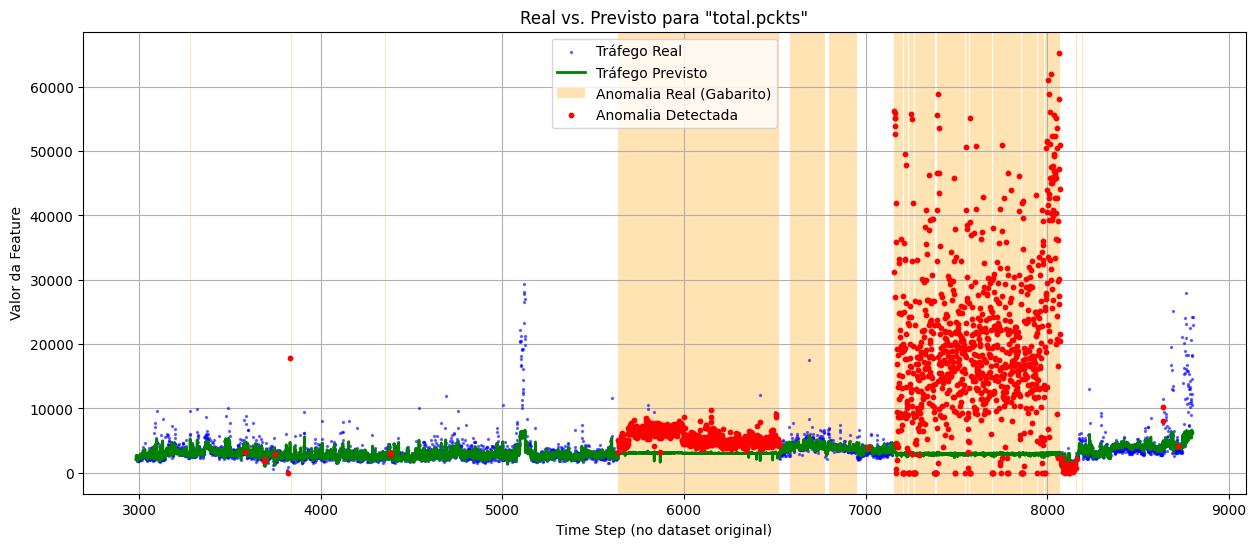

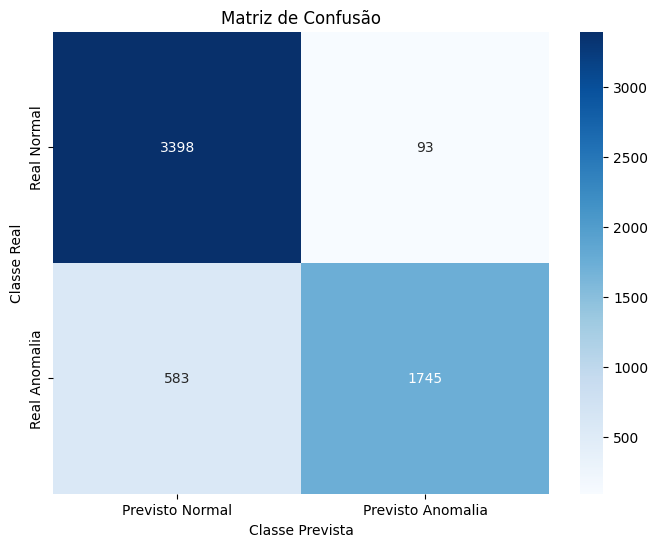


===== AVALIAÇÃO COM Z-SCORE THRESHOLD = 60.00 =====
TP: 1750, TN: 3397, FP: 94, FN: 578
Acurácia: 0.8845, Precisão Ponderada: 0.8924, Recall Ponderado: 0.8845


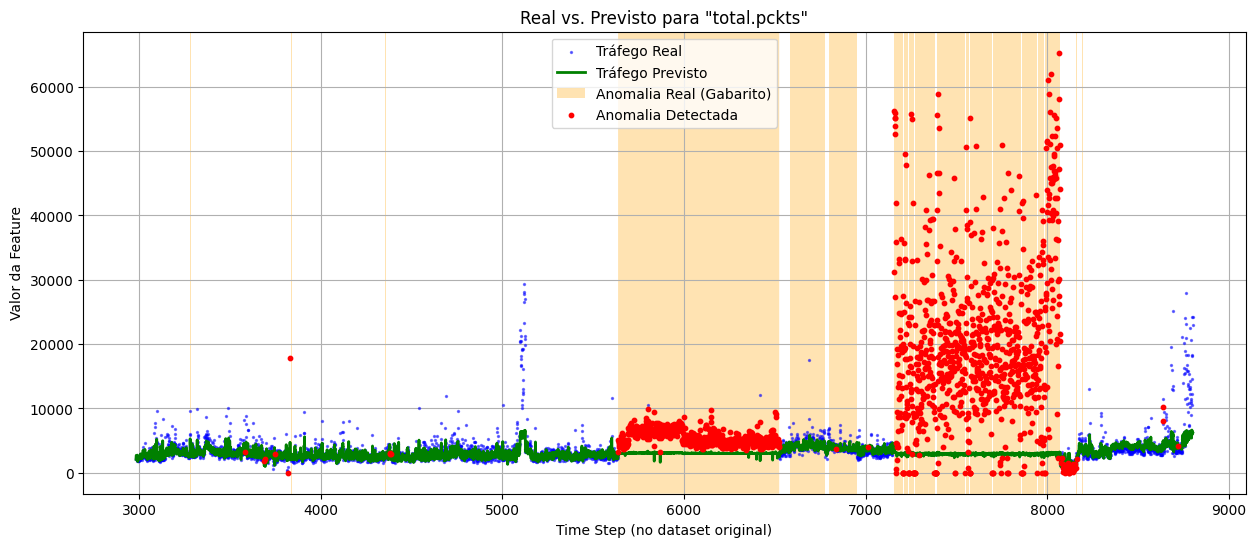

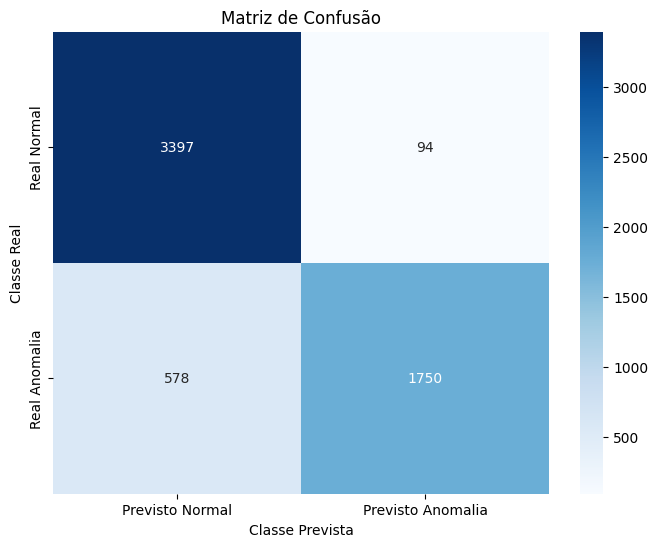


===== AVALIAÇÃO COM Z-SCORE THRESHOLD = 55.00 =====
TP: 1750, TN: 3397, FP: 94, FN: 578
Acurácia: 0.8845, Precisão Ponderada: 0.8924, Recall Ponderado: 0.8845


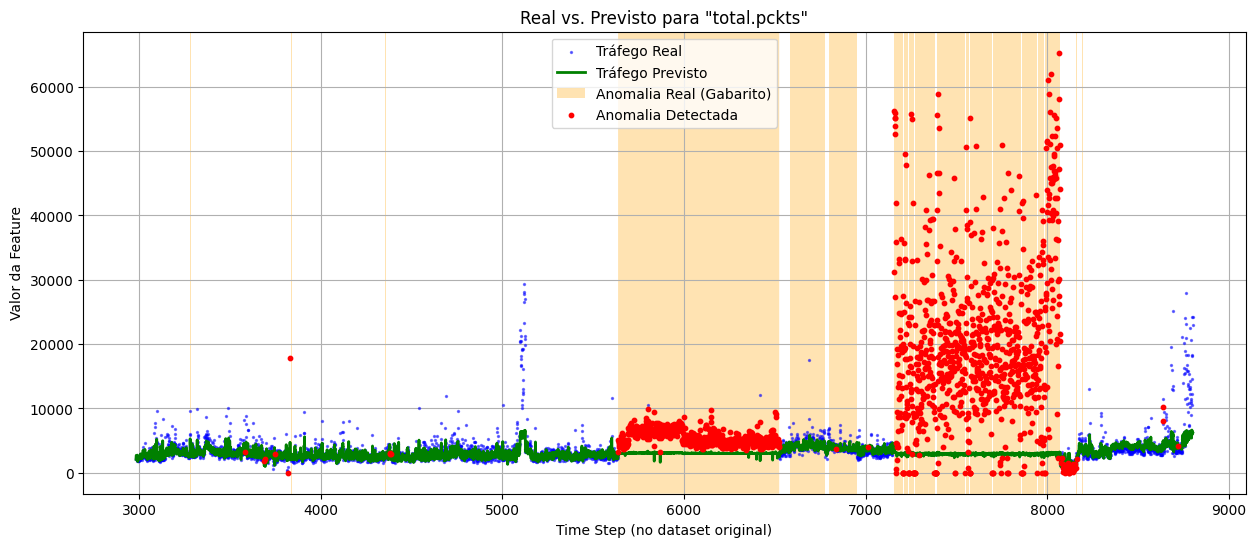

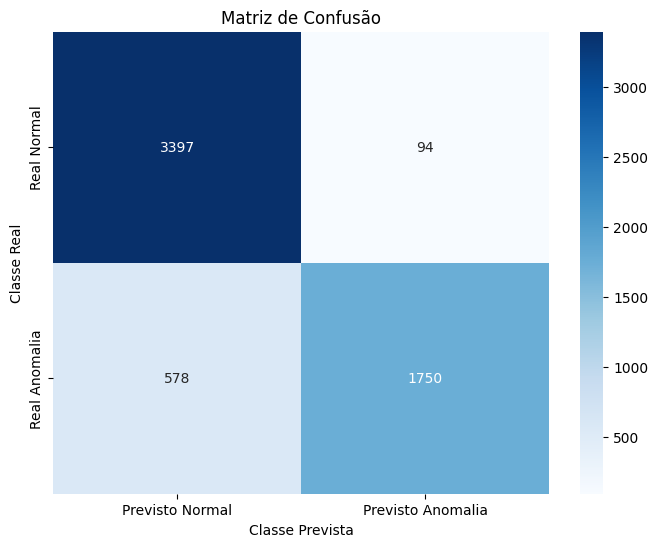


===== AVALIAÇÃO COM Z-SCORE THRESHOLD = 50.00 =====
TP: 1751, TN: 3395, FP: 96, FN: 577
Acurácia: 0.8843, Precisão Ponderada: 0.8921, Recall Ponderado: 0.8843


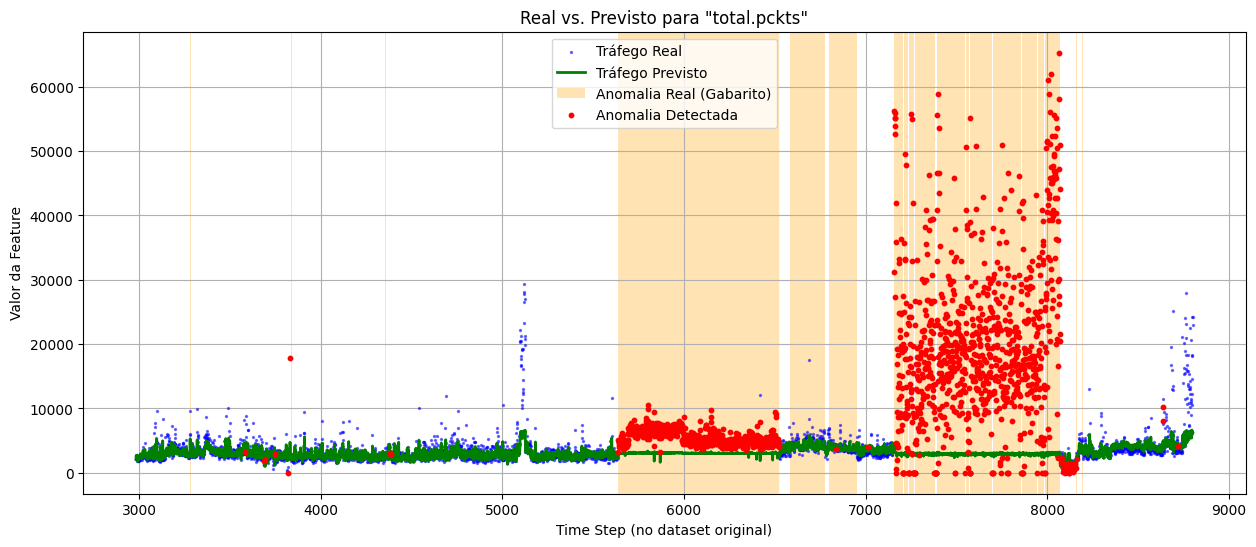

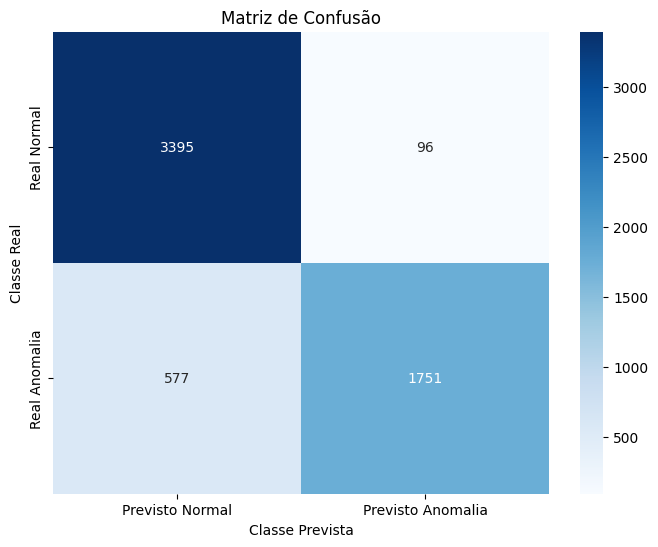


===== AVALIAÇÃO COM Z-SCORE THRESHOLD = 45.00 =====
TP: 1751, TN: 3392, FP: 99, FN: 577
Acurácia: 0.8838, Precisão Ponderada: 0.8914, Recall Ponderado: 0.8838


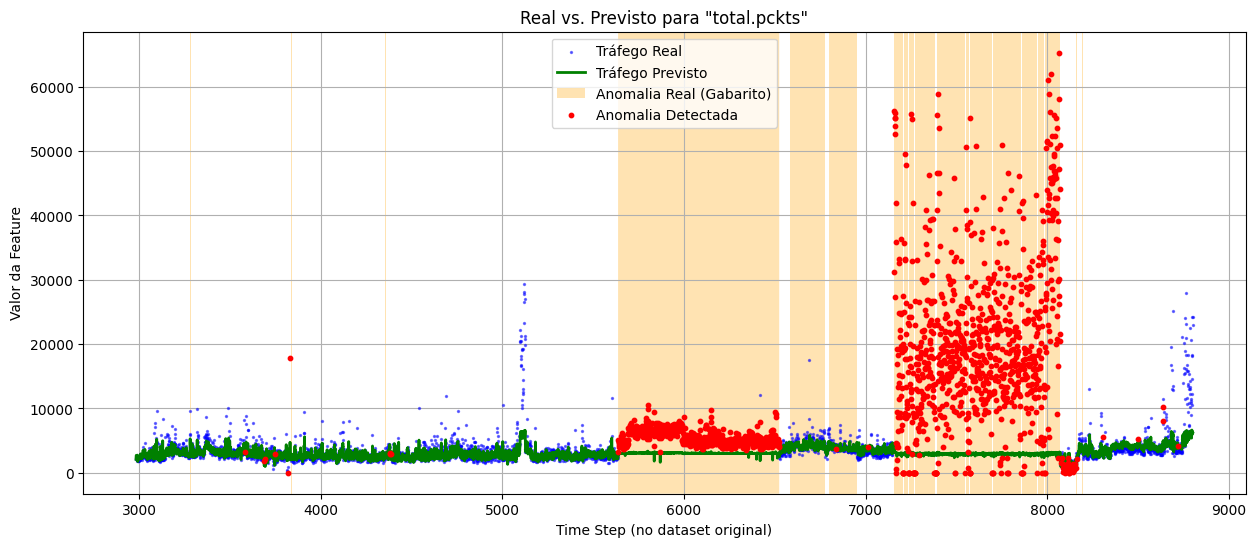

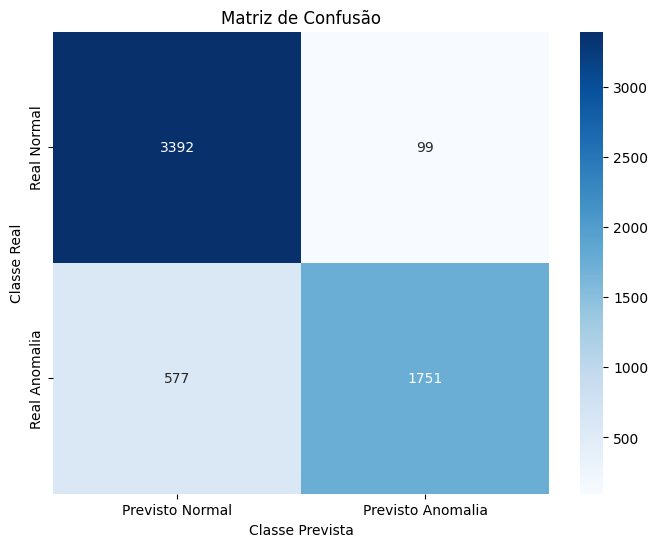


===== AVALIAÇÃO COM Z-SCORE THRESHOLD = 40.00 =====
TP: 1751, TN: 3392, FP: 99, FN: 577
Acurácia: 0.8838, Precisão Ponderada: 0.8914, Recall Ponderado: 0.8838


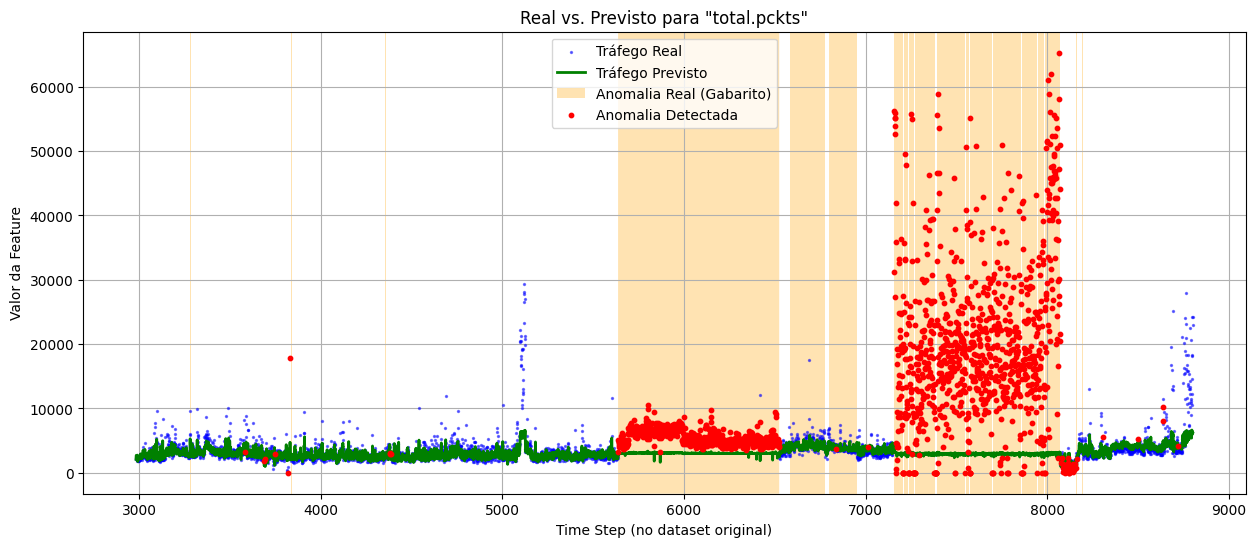

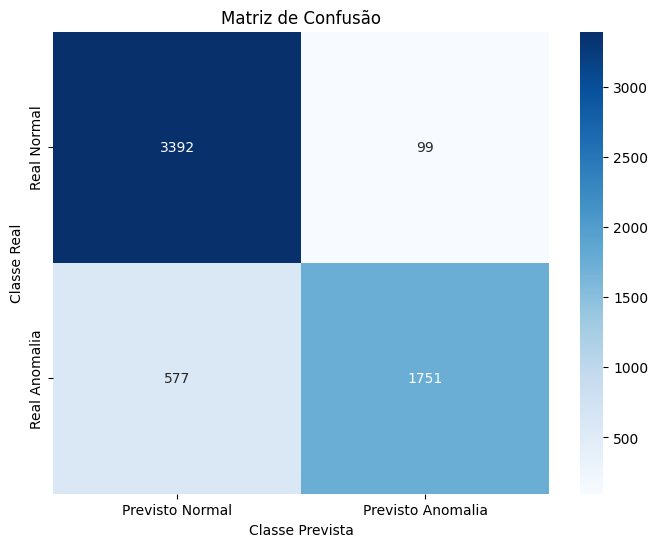


===== AVALIAÇÃO COM Z-SCORE THRESHOLD = 35.00 =====
TP: 1752, TN: 3391, FP: 100, FN: 576
Acurácia: 0.8838, Precisão Ponderada: 0.8913, Recall Ponderado: 0.8838


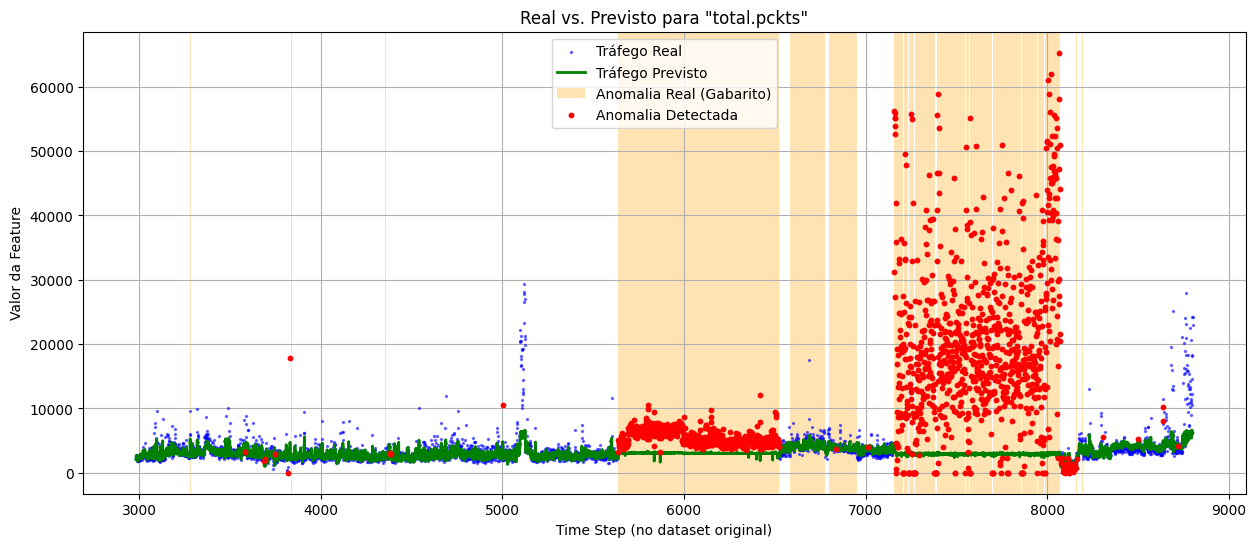

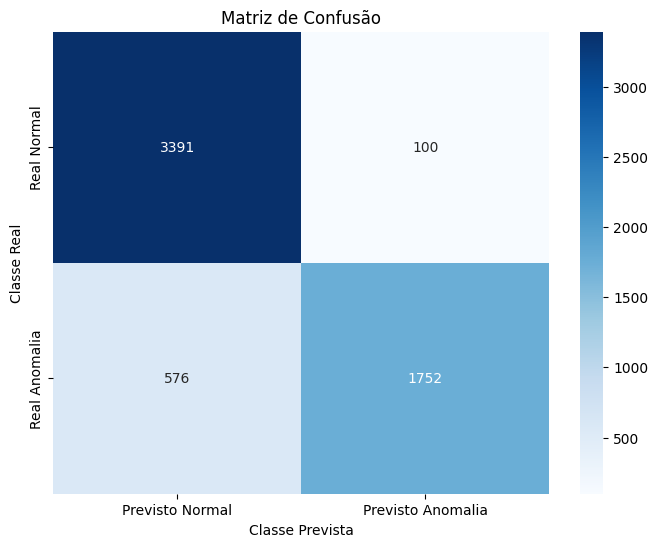


===== AVALIAÇÃO COM Z-SCORE THRESHOLD = 30.00 =====
TP: 1752, TN: 3386, FP: 105, FN: 576
Acurácia: 0.8830, Precisão Ponderada: 0.8902, Recall Ponderado: 0.8830


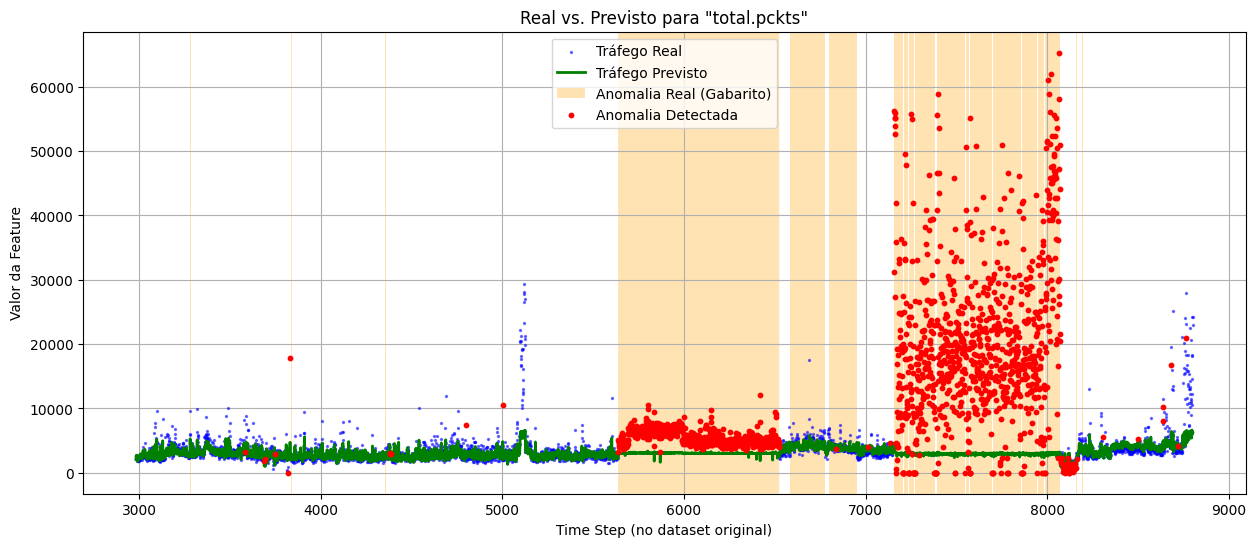

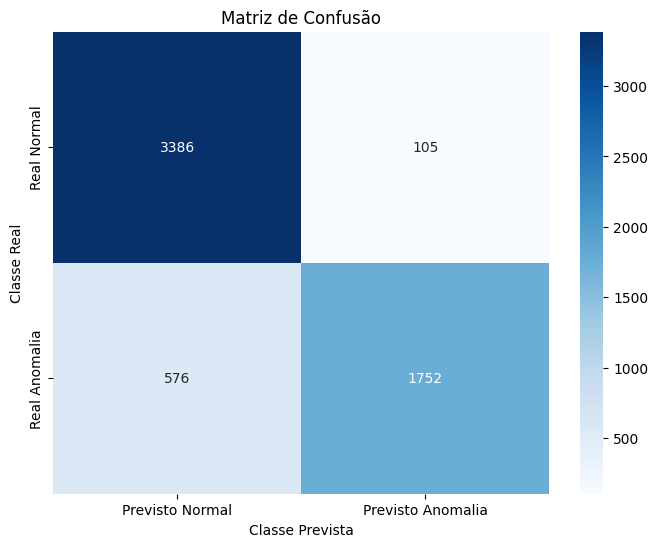


===== AVALIAÇÃO COM Z-SCORE THRESHOLD = 25.00 =====
TP: 1753, TN: 3383, FP: 108, FN: 575
Acurácia: 0.8826, Precisão Ponderada: 0.8896, Recall Ponderado: 0.8826


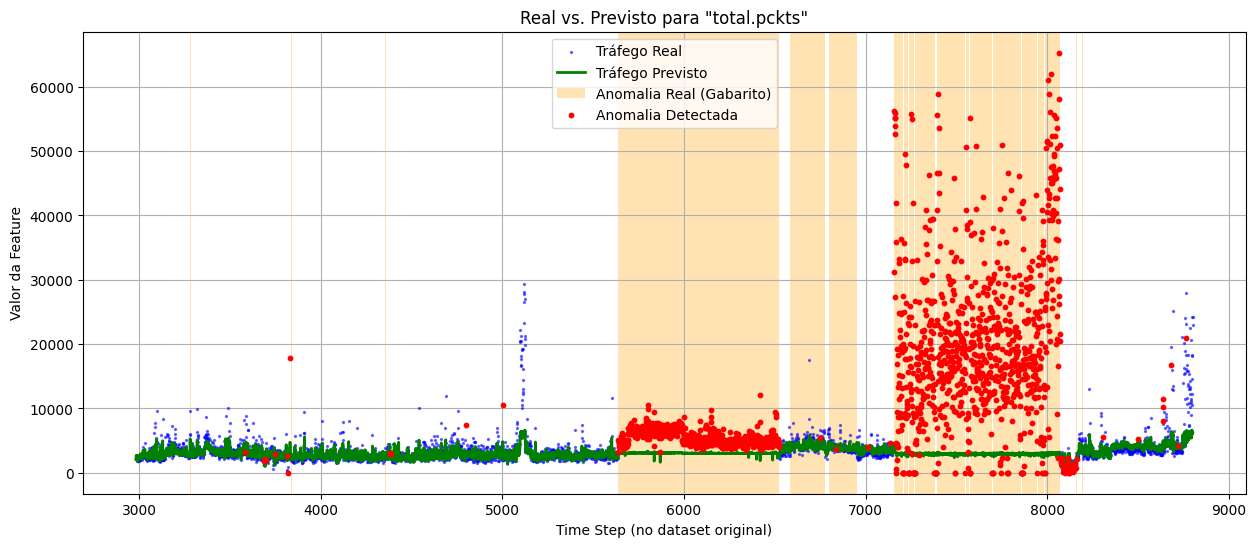

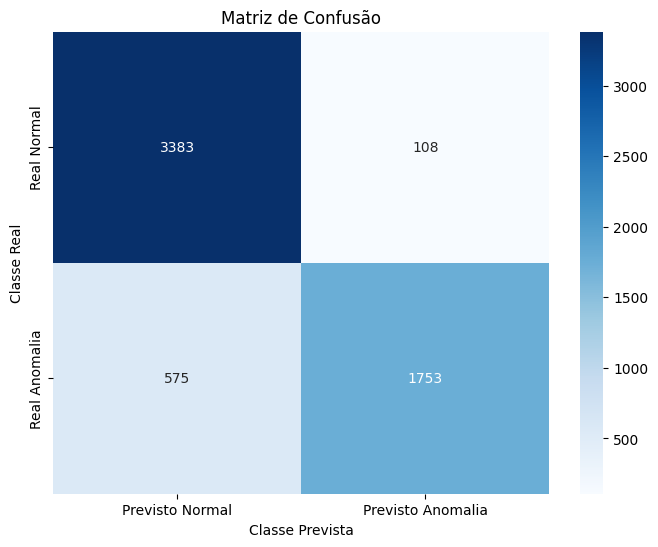


===== AVALIAÇÃO COM Z-SCORE THRESHOLD = 20.00 =====
TP: 1753, TN: 3376, FP: 115, FN: 575
Acurácia: 0.8814, Precisão Ponderada: 0.8881, Recall Ponderado: 0.8814


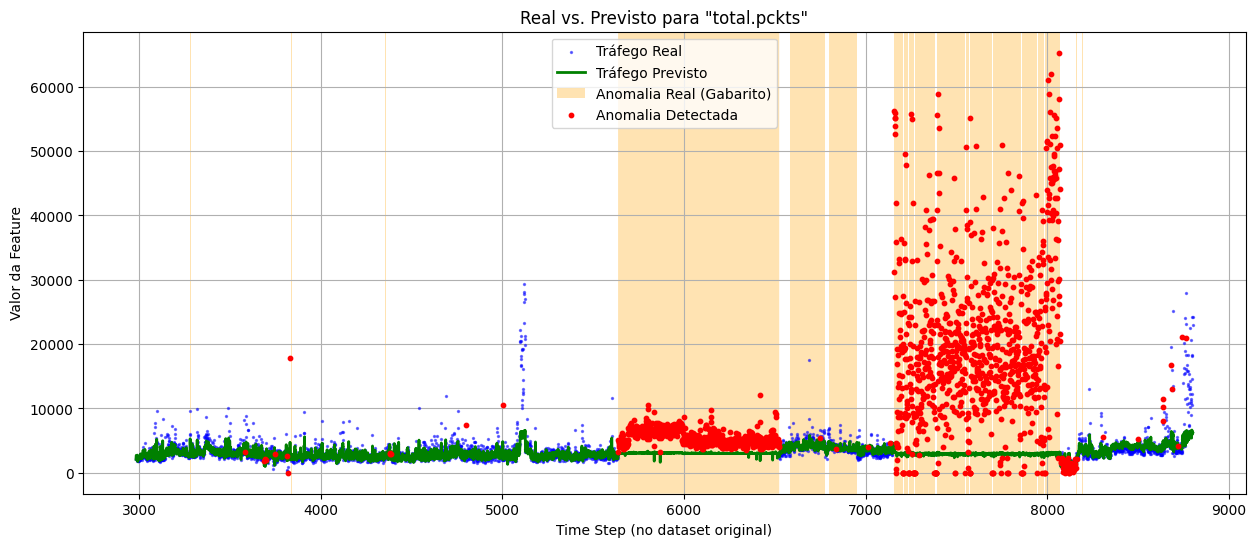

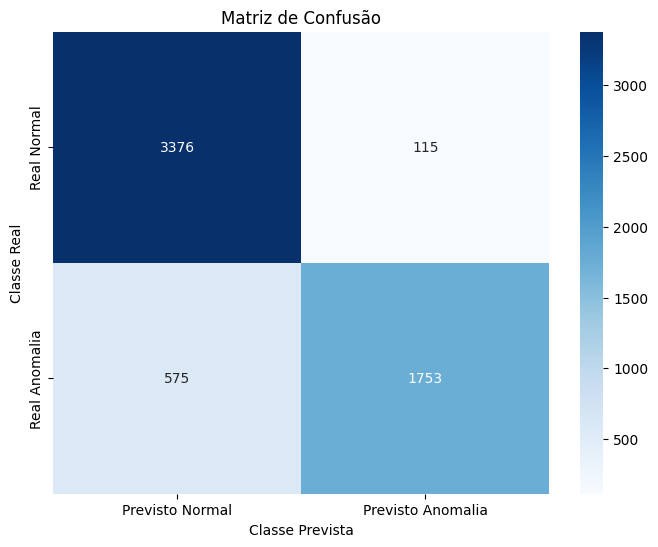


===== AVALIAÇÃO COM Z-SCORE THRESHOLD = 15.00 =====
TP: 1754, TN: 3368, FP: 123, FN: 574
Acurácia: 0.8802, Precisão Ponderada: 0.8864, Recall Ponderado: 0.8802


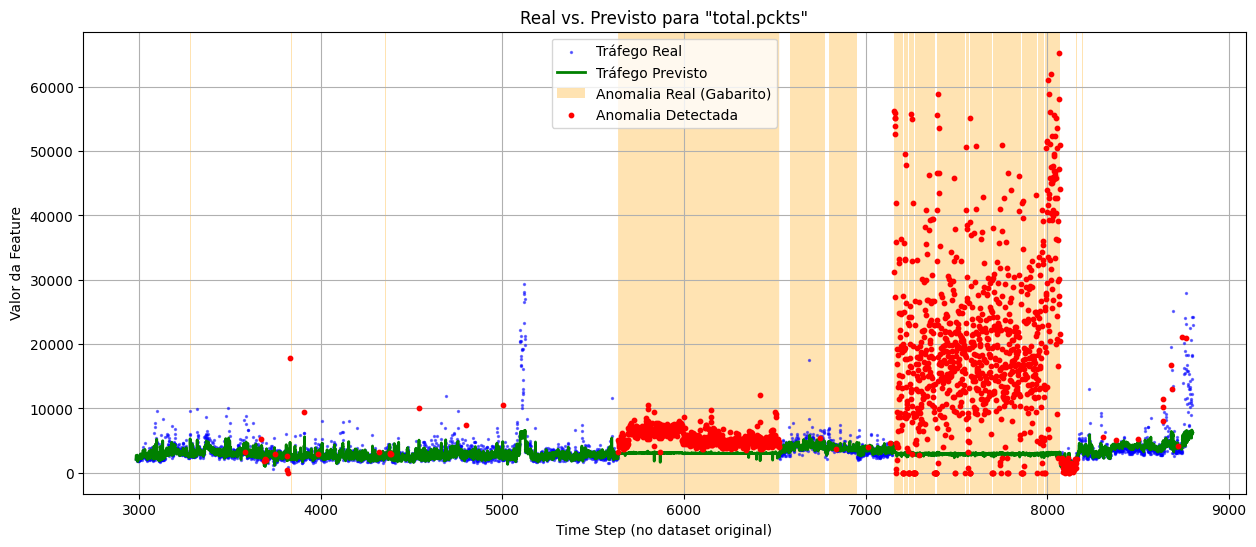

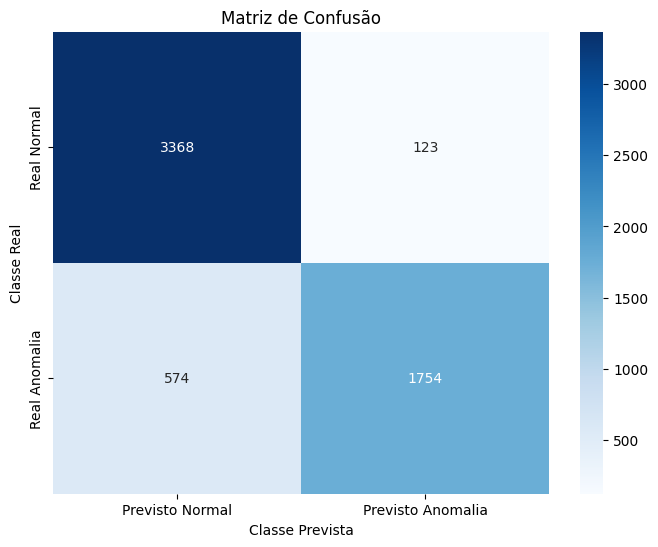


===== AVALIAÇÃO COM Z-SCORE THRESHOLD = 12.50 =====
TP: 1756, TN: 3356, FP: 135, FN: 572
Acurácia: 0.8785, Precisão Ponderada: 0.8841, Recall Ponderado: 0.8785


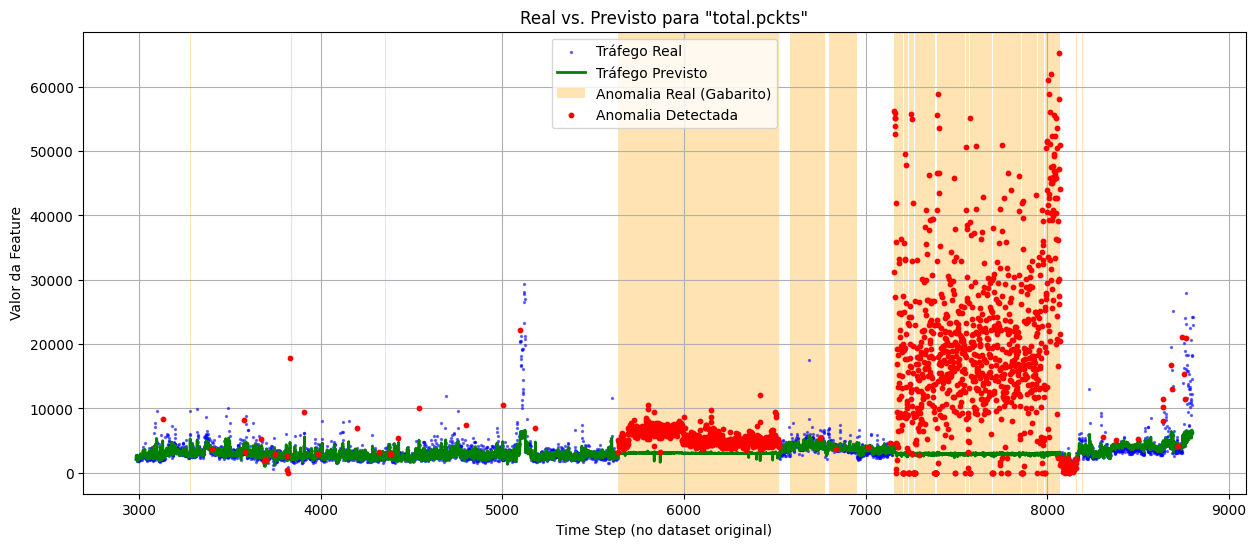

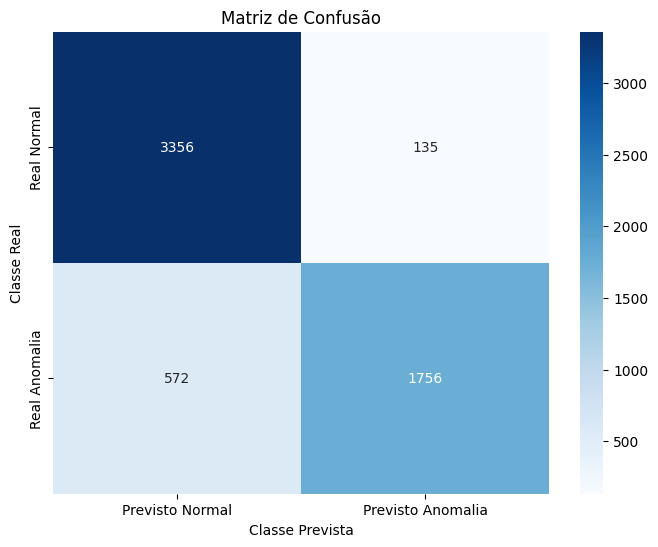



========================= RESUMO DO EXPERIMENTO: CAP 51 =========================
               Dataset  Z-Score Thresh    TP    TN   FP   FN  Acurácia  Precisão Ponderada  Recall Ponderado     Tempo de Predição
0   cap51processed.csv            70.0  1745  3398   93  583  0.883829            0.891900          0.883829   Antecipação: 34m 9s
1   cap51processed.csv            60.0  1750  3397   94  578  0.884516            0.892371          0.884516   Antecipação: 34m 9s
2   cap51processed.csv            55.0  1750  3397   94  578  0.884516            0.892371          0.884516   Antecipação: 34m 9s
3   cap51processed.csv            50.0  1751  3395   96  577  0.884344            0.892056          0.884344   Antecipação: 34m 9s
4   cap51processed.csv            45.0  1751  3392   99  577  0.883829            0.891375          0.883829   Antecipação: 34m 9s
5   cap51processed.csv            40.0  1751  3392   99  577  0.883829            0.891375          0.883829   Antecipação: 34m 9s

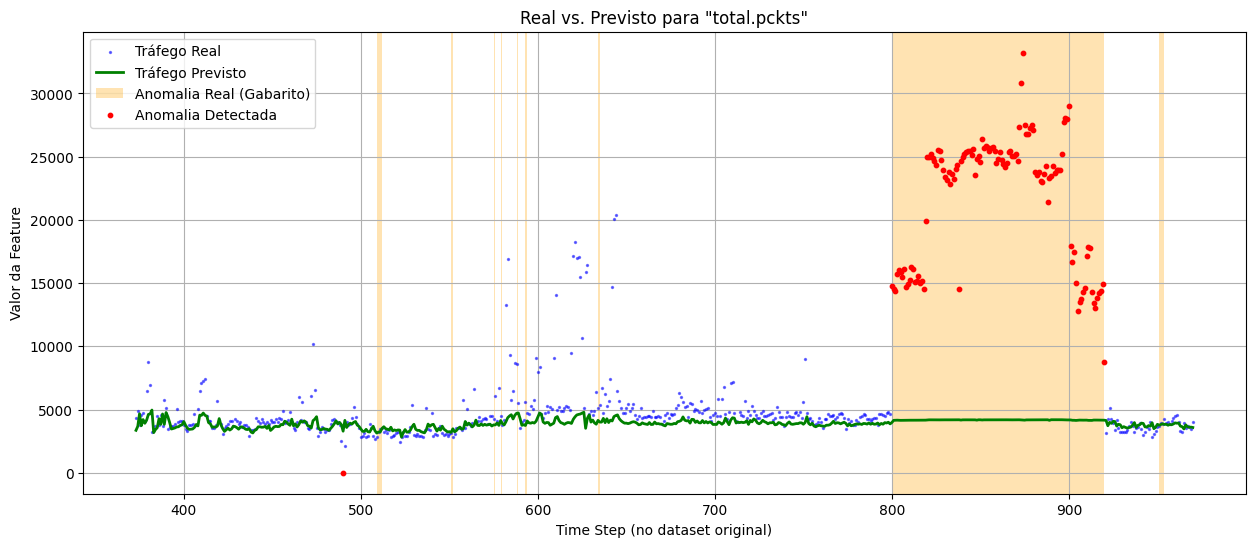

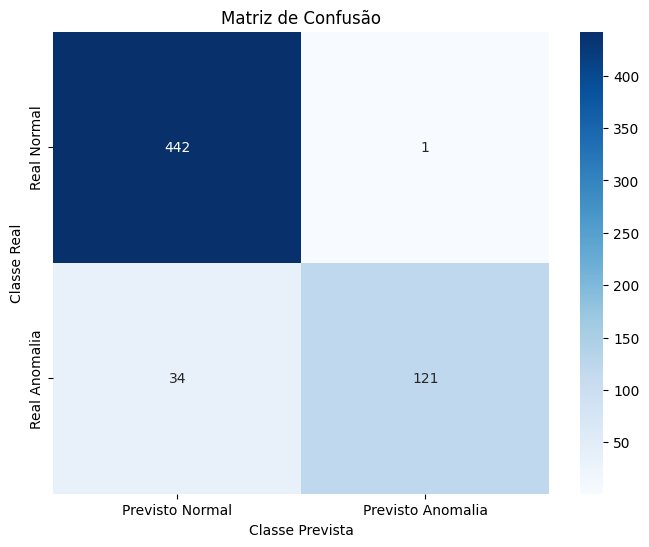


===== AVALIAÇÃO COM Z-SCORE THRESHOLD = 150.00 =====
TP: 121, TN: 442, FP: 1, FN: 34
Acurácia: 0.9415, Precisão Ponderada: 0.9450, Recall Ponderado: 0.9415


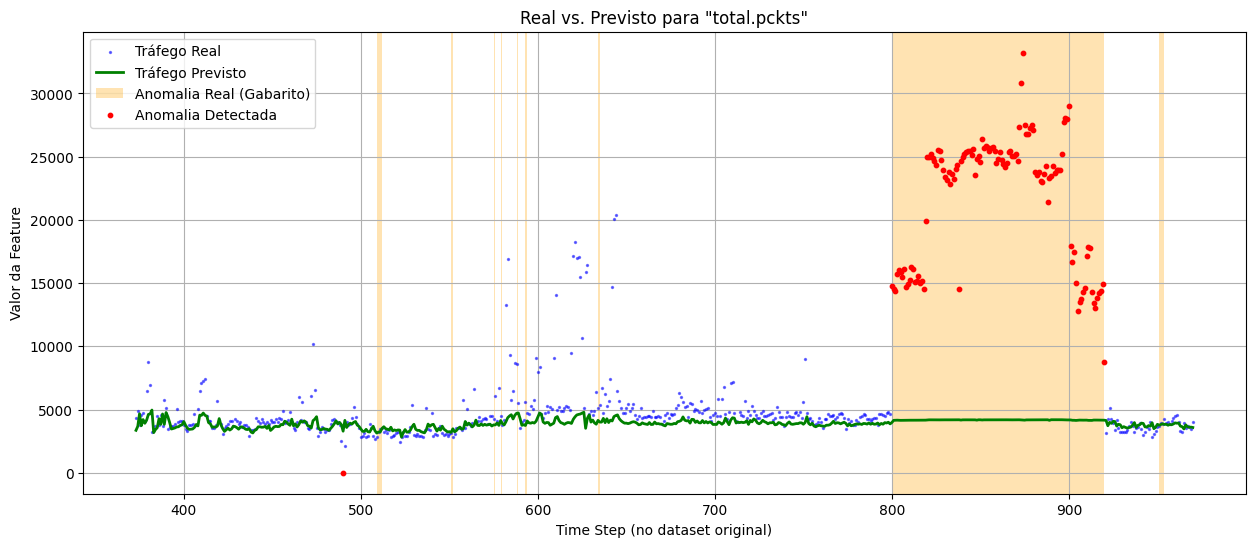

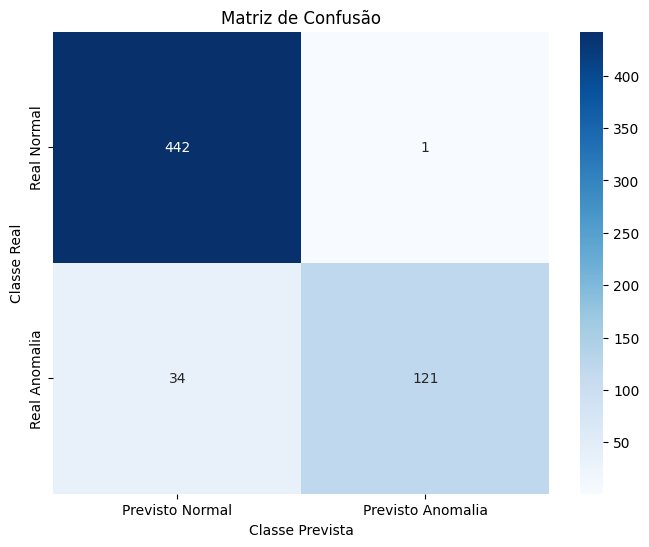


===== AVALIAÇÃO COM Z-SCORE THRESHOLD = 140.00 =====
TP: 121, TN: 442, FP: 1, FN: 34
Acurácia: 0.9415, Precisão Ponderada: 0.9450, Recall Ponderado: 0.9415


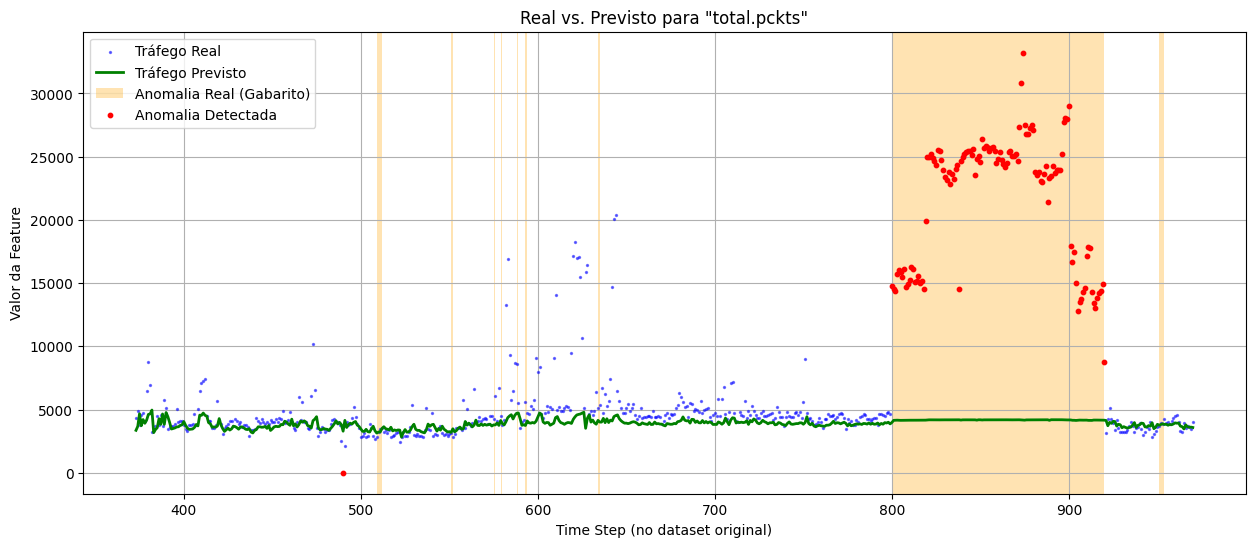

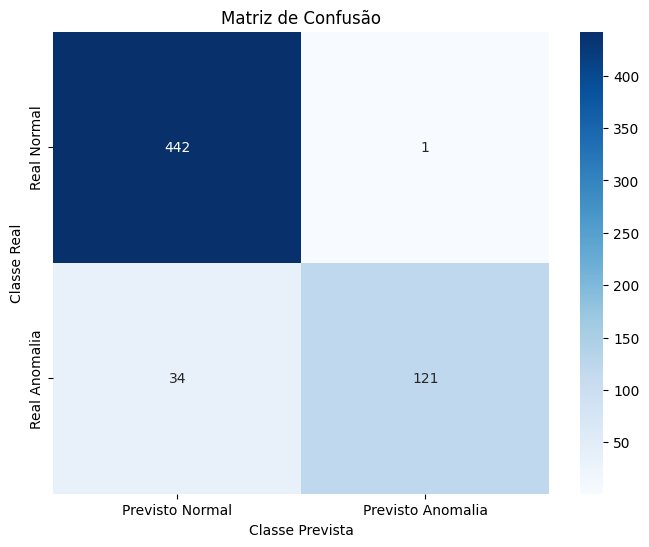


===== AVALIAÇÃO COM Z-SCORE THRESHOLD = 130.00 =====
TP: 121, TN: 442, FP: 1, FN: 34
Acurácia: 0.9415, Precisão Ponderada: 0.9450, Recall Ponderado: 0.9415


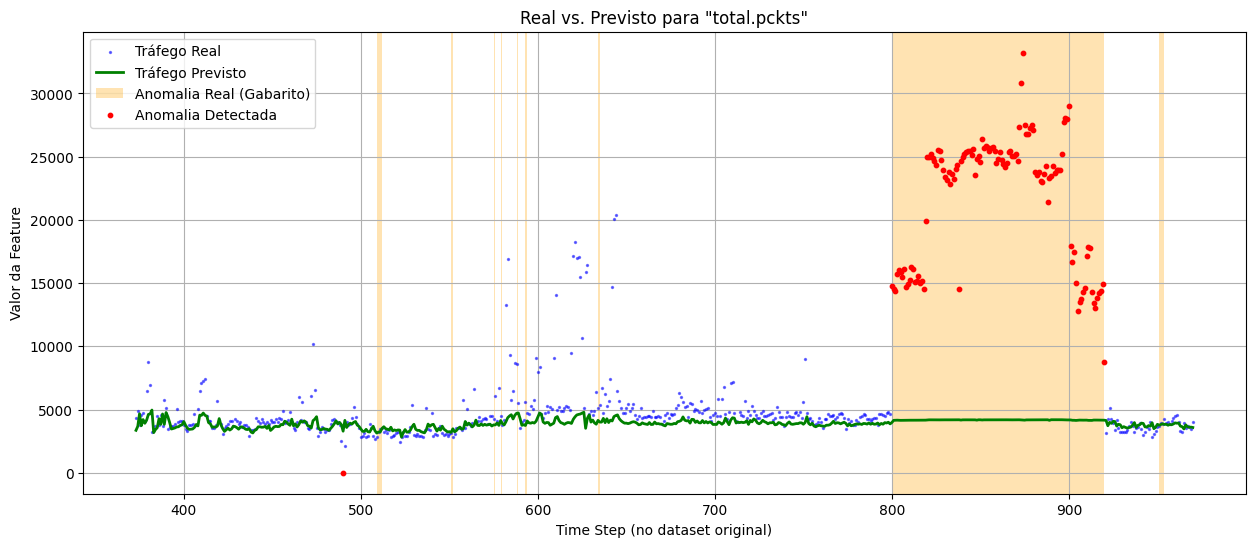

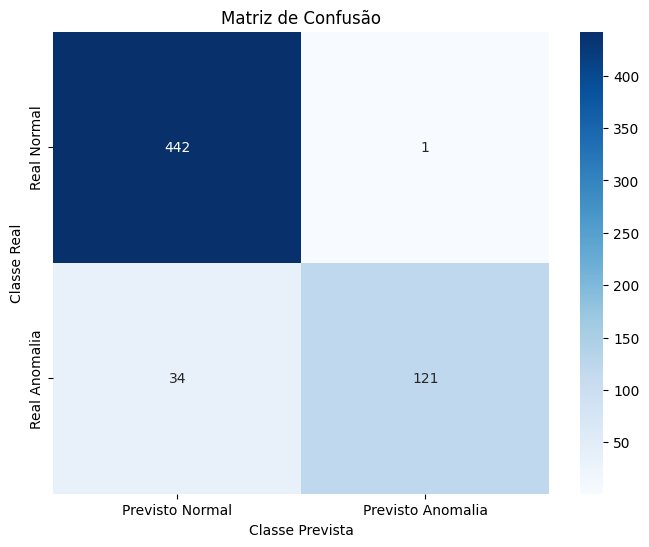


===== AVALIAÇÃO COM Z-SCORE THRESHOLD = 125.00 =====
TP: 121, TN: 442, FP: 1, FN: 34
Acurácia: 0.9415, Precisão Ponderada: 0.9450, Recall Ponderado: 0.9415


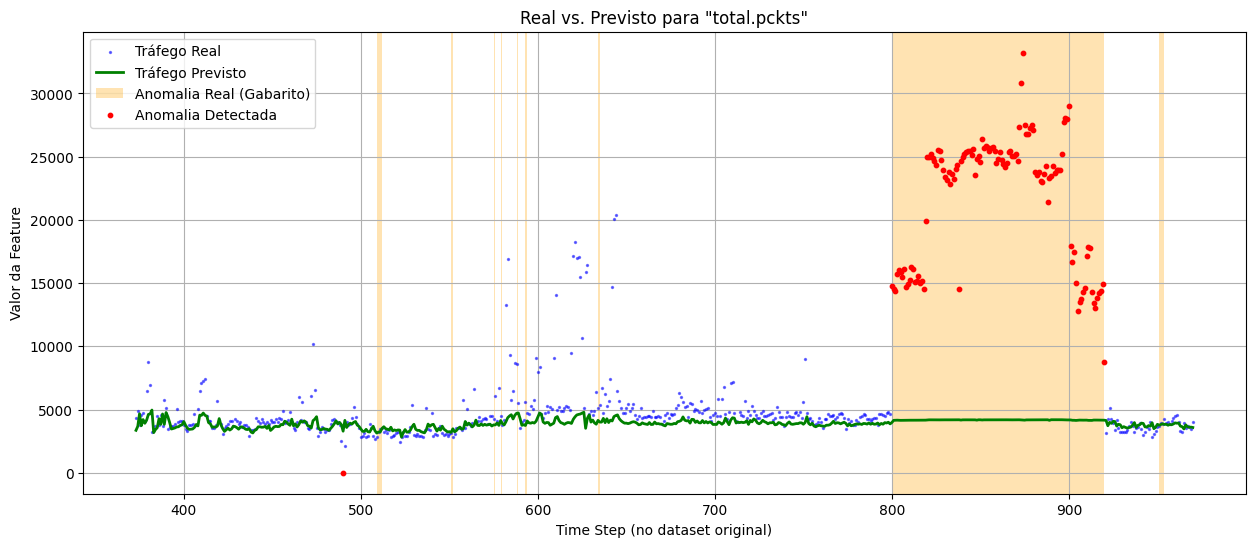

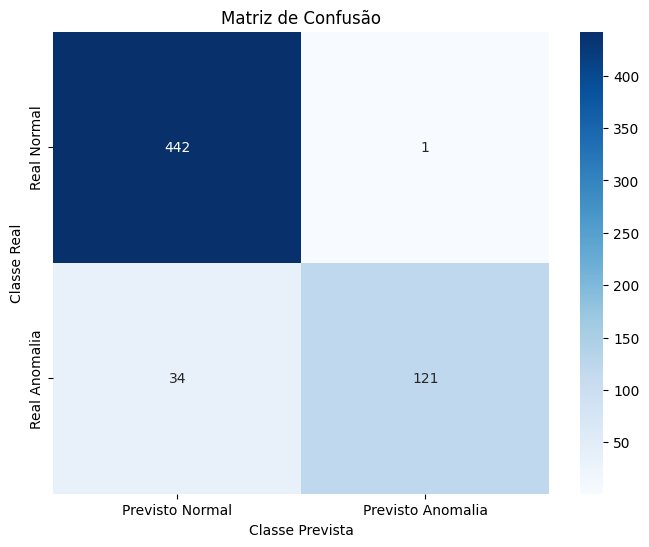


===== AVALIAÇÃO COM Z-SCORE THRESHOLD = 120.00 =====
TP: 121, TN: 442, FP: 1, FN: 34
Acurácia: 0.9415, Precisão Ponderada: 0.9450, Recall Ponderado: 0.9415


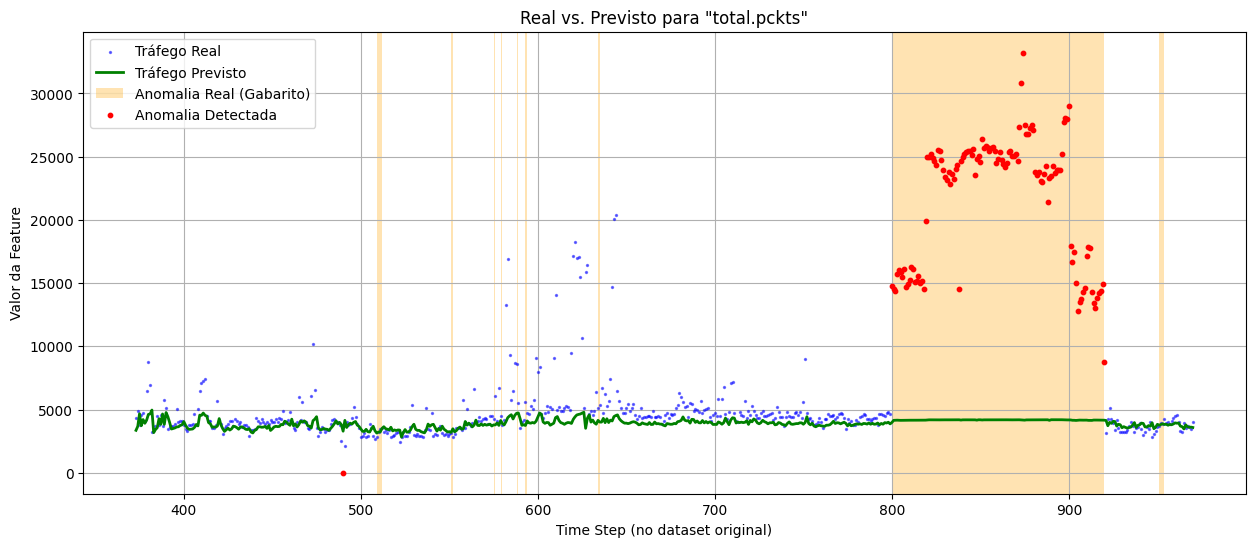

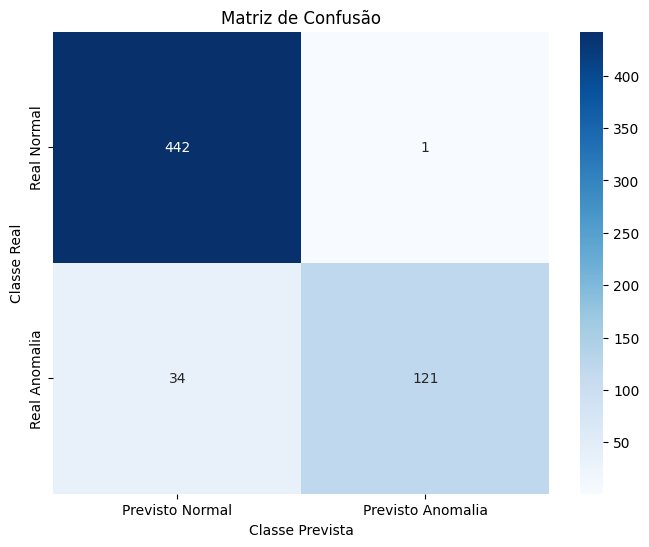


===== AVALIAÇÃO COM Z-SCORE THRESHOLD = 110.00 =====
TP: 121, TN: 442, FP: 1, FN: 34
Acurácia: 0.9415, Precisão Ponderada: 0.9450, Recall Ponderado: 0.9415


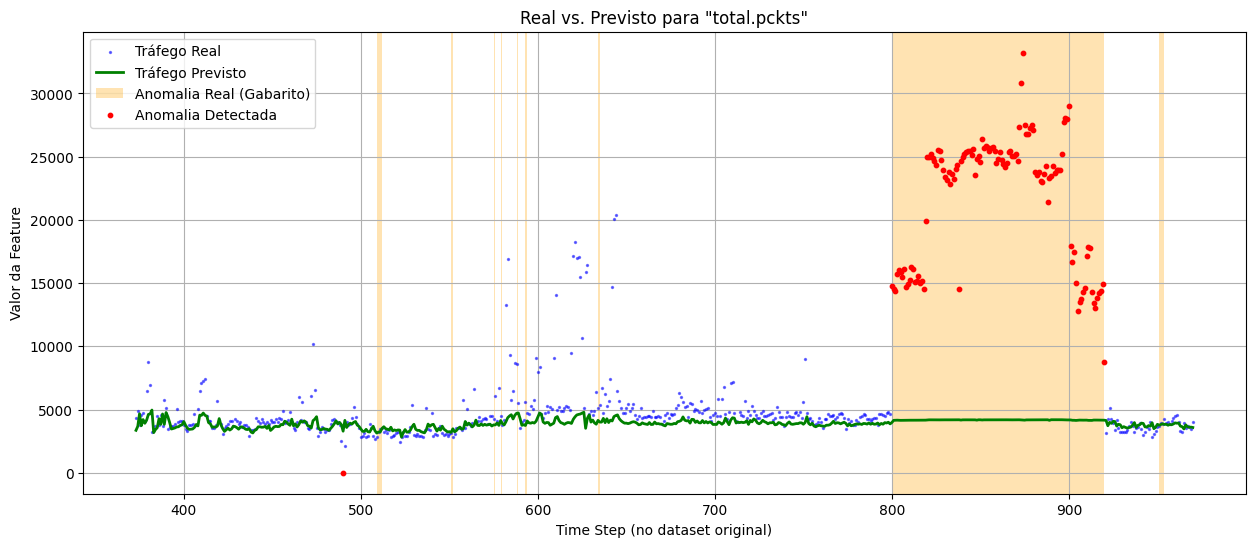

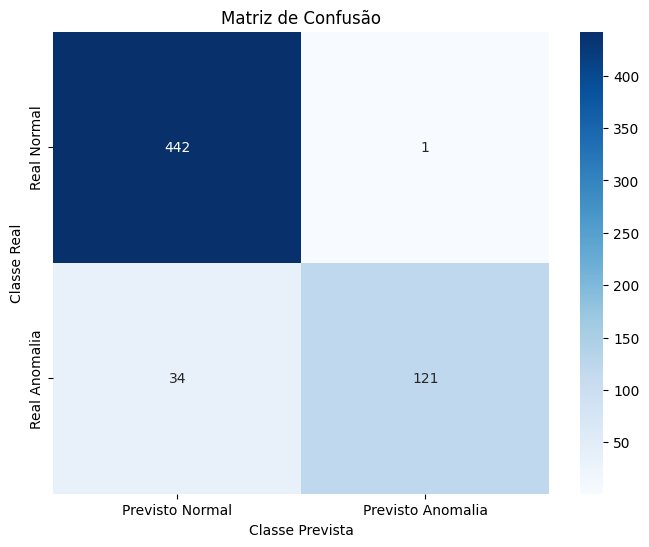


===== AVALIAÇÃO COM Z-SCORE THRESHOLD = 100.00 =====
TP: 121, TN: 442, FP: 1, FN: 34
Acurácia: 0.9415, Precisão Ponderada: 0.9450, Recall Ponderado: 0.9415


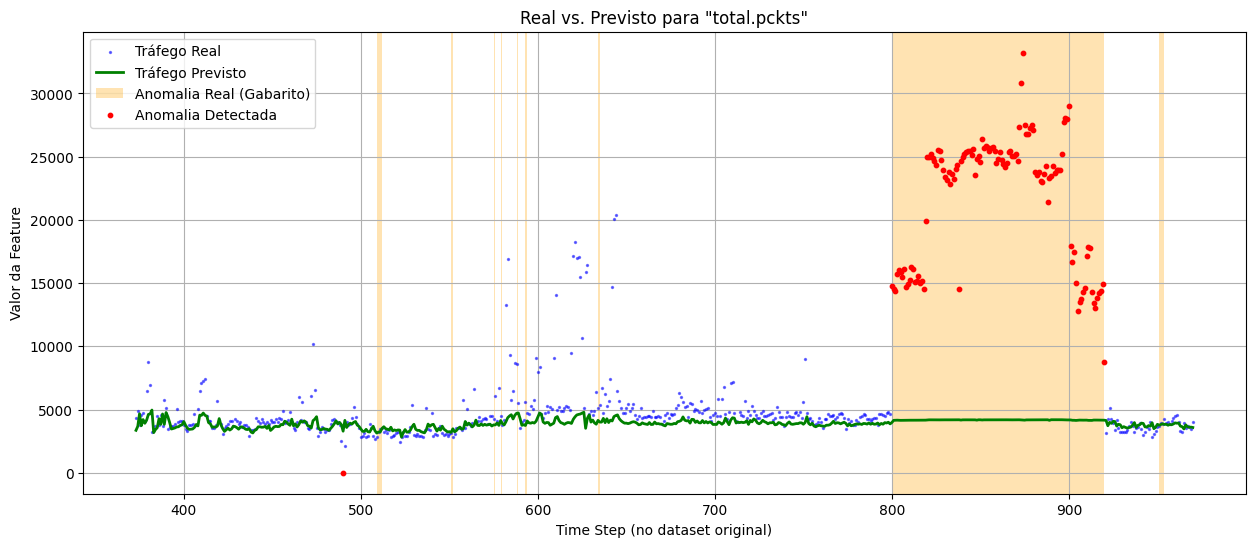

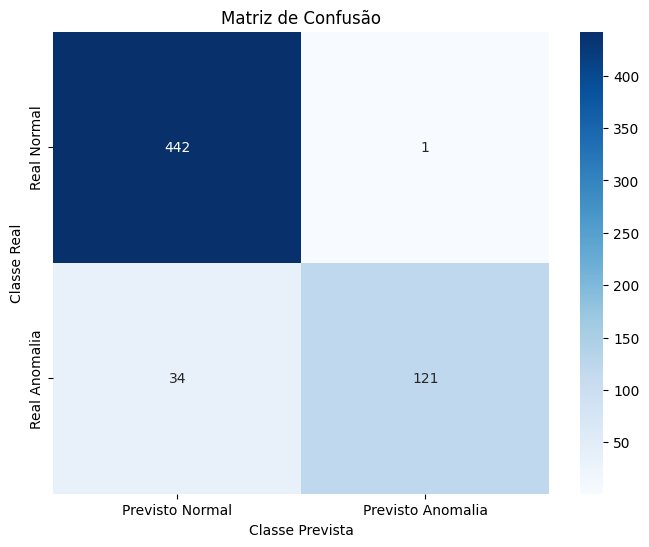


===== AVALIAÇÃO COM Z-SCORE THRESHOLD = 95.00 =====
TP: 121, TN: 442, FP: 1, FN: 34
Acurácia: 0.9415, Precisão Ponderada: 0.9450, Recall Ponderado: 0.9415


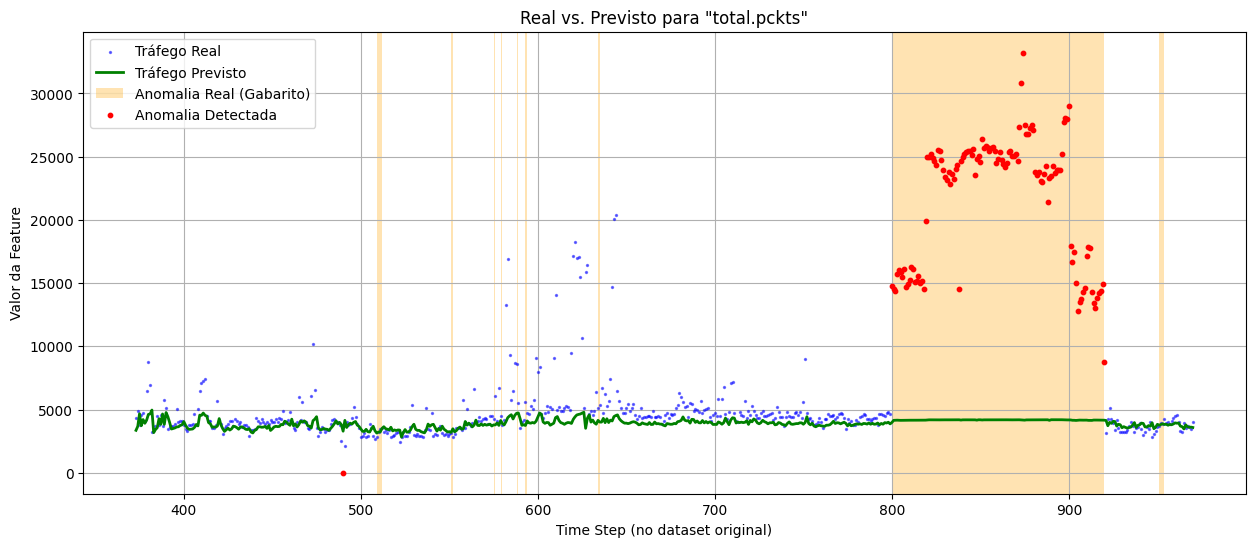

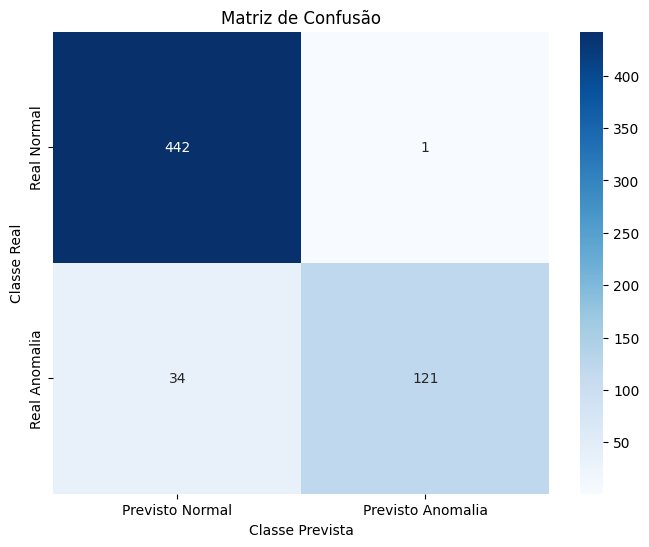


===== AVALIAÇÃO COM Z-SCORE THRESHOLD = 90.00 =====
TP: 121, TN: 441, FP: 2, FN: 34
Acurácia: 0.9398, Precisão Ponderada: 0.9428, Recall Ponderado: 0.9398


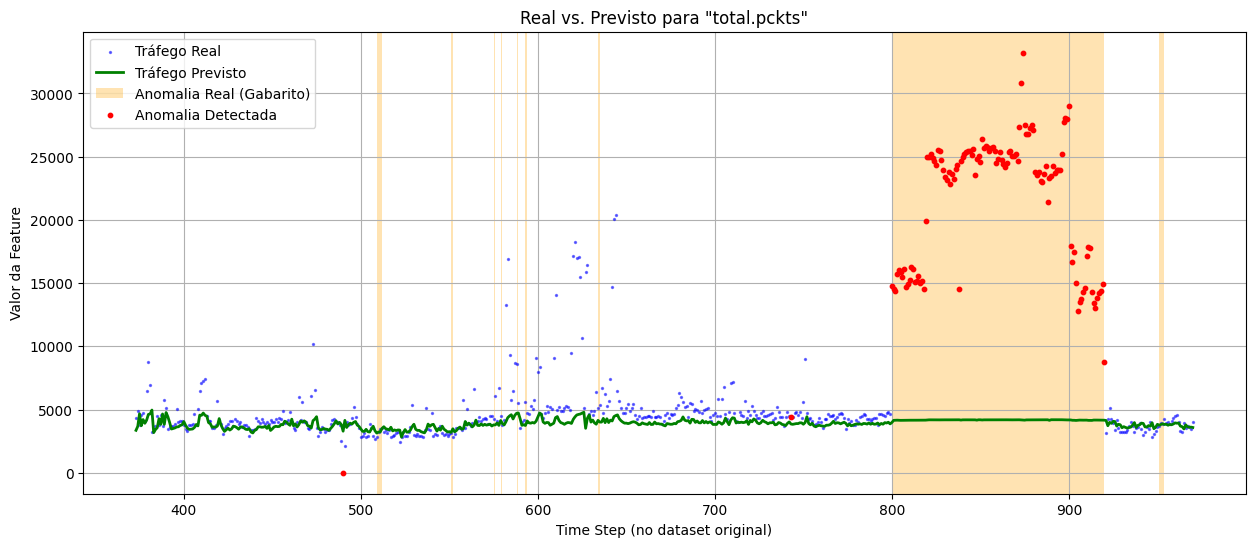

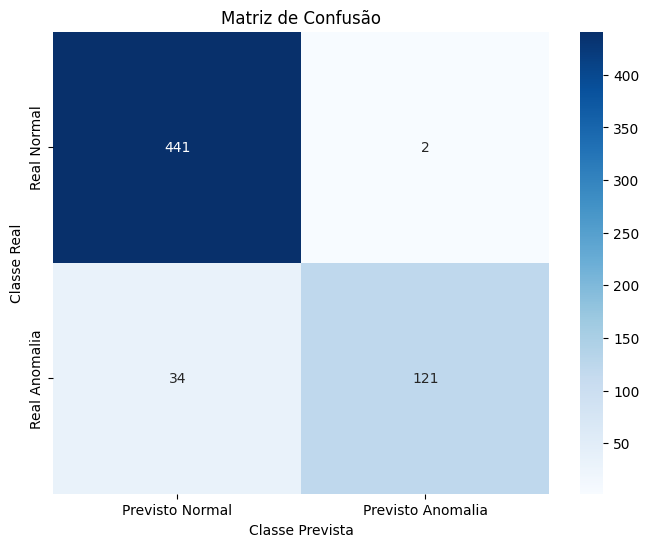


===== AVALIAÇÃO COM Z-SCORE THRESHOLD = 85.00 =====
TP: 121, TN: 441, FP: 2, FN: 34
Acurácia: 0.9398, Precisão Ponderada: 0.9428, Recall Ponderado: 0.9398


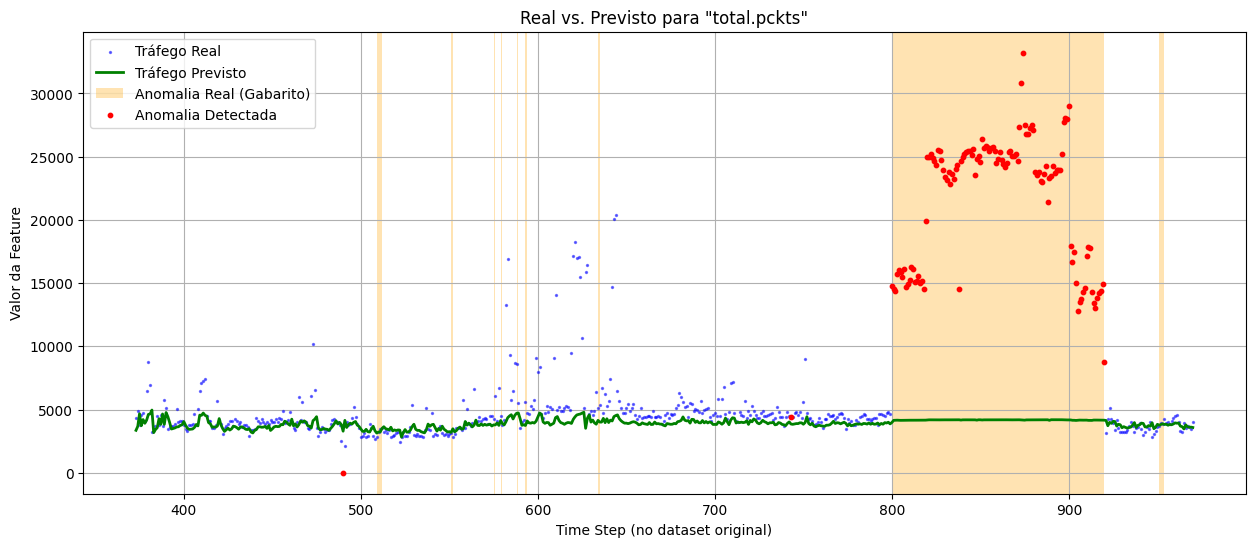

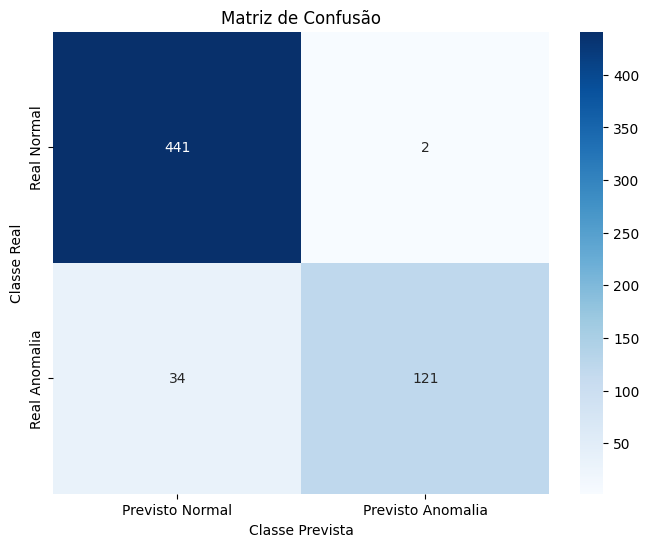


===== AVALIAÇÃO COM Z-SCORE THRESHOLD = 80.00 =====
TP: 121, TN: 440, FP: 3, FN: 34
Acurácia: 0.9381, Precisão Ponderada: 0.9406, Recall Ponderado: 0.9381


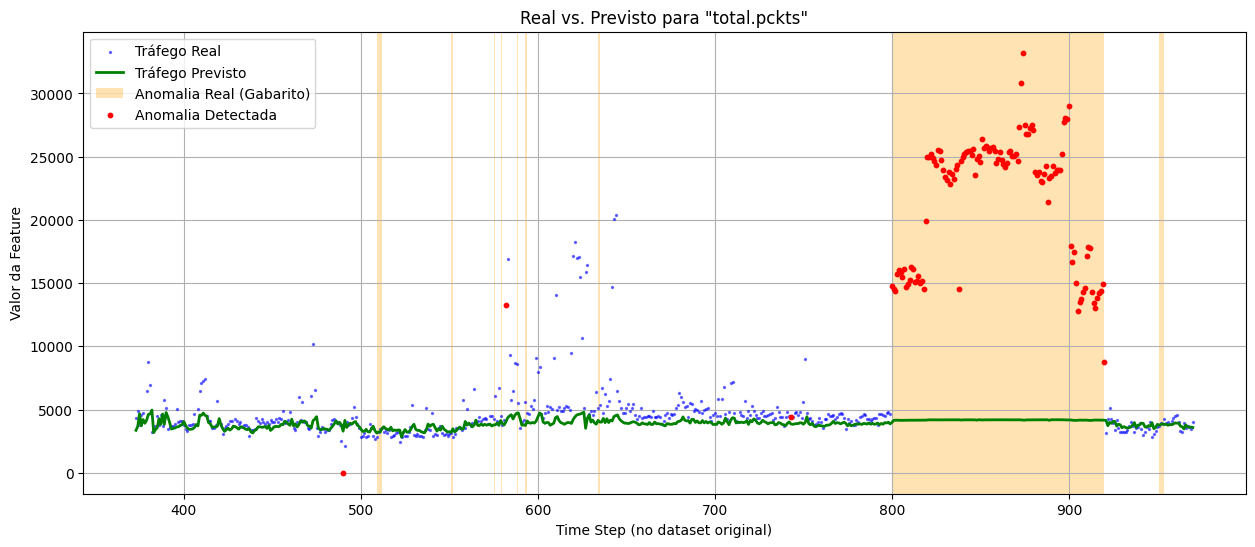

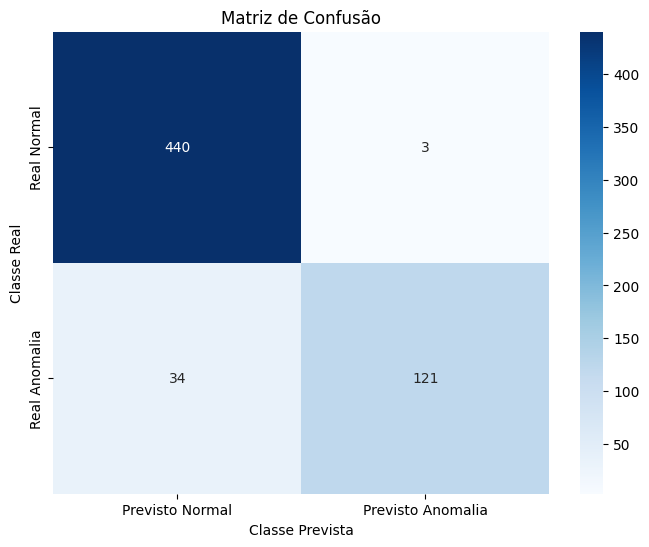


===== AVALIAÇÃO COM Z-SCORE THRESHOLD = 75.00 =====
TP: 121, TN: 440, FP: 3, FN: 34
Acurácia: 0.9381, Precisão Ponderada: 0.9406, Recall Ponderado: 0.9381


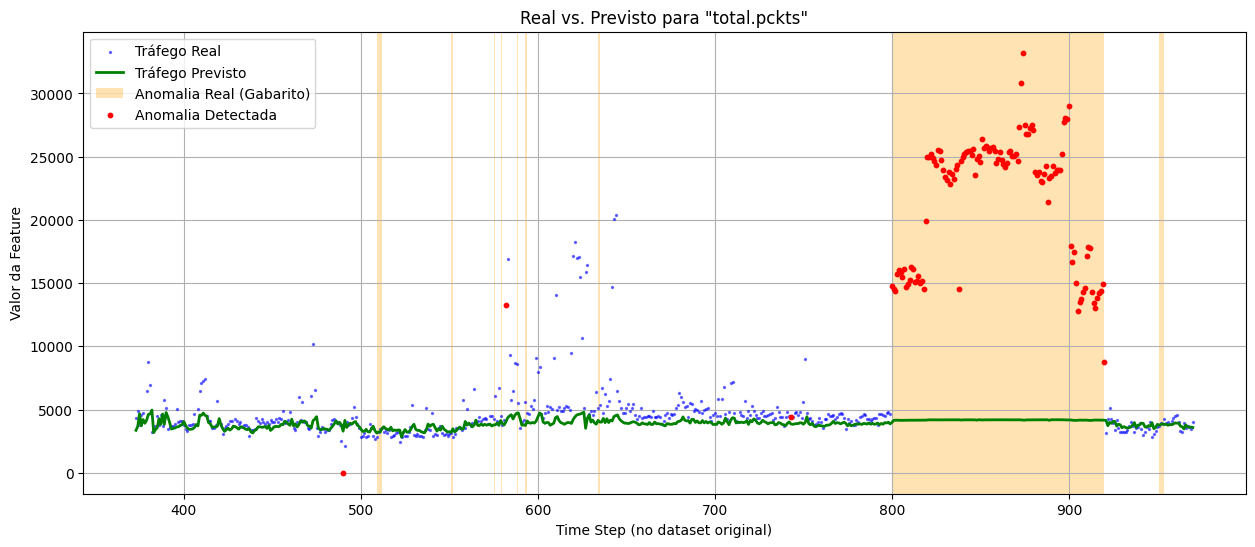

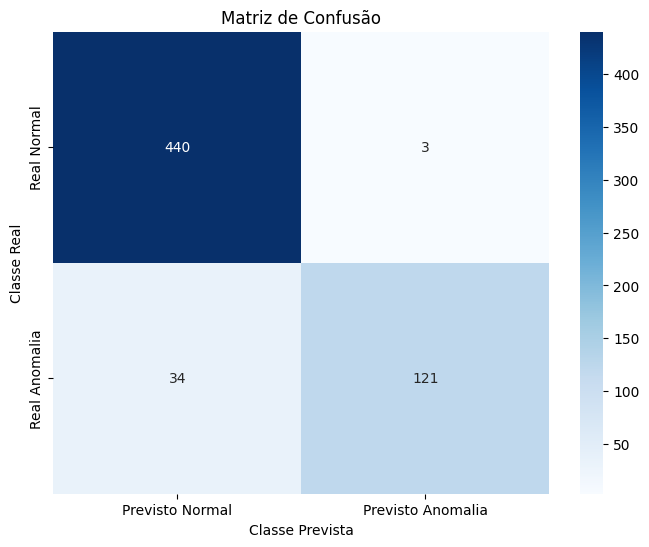


===== AVALIAÇÃO COM Z-SCORE THRESHOLD = 70.00 =====
TP: 121, TN: 440, FP: 3, FN: 34
Acurácia: 0.9381, Precisão Ponderada: 0.9406, Recall Ponderado: 0.9381


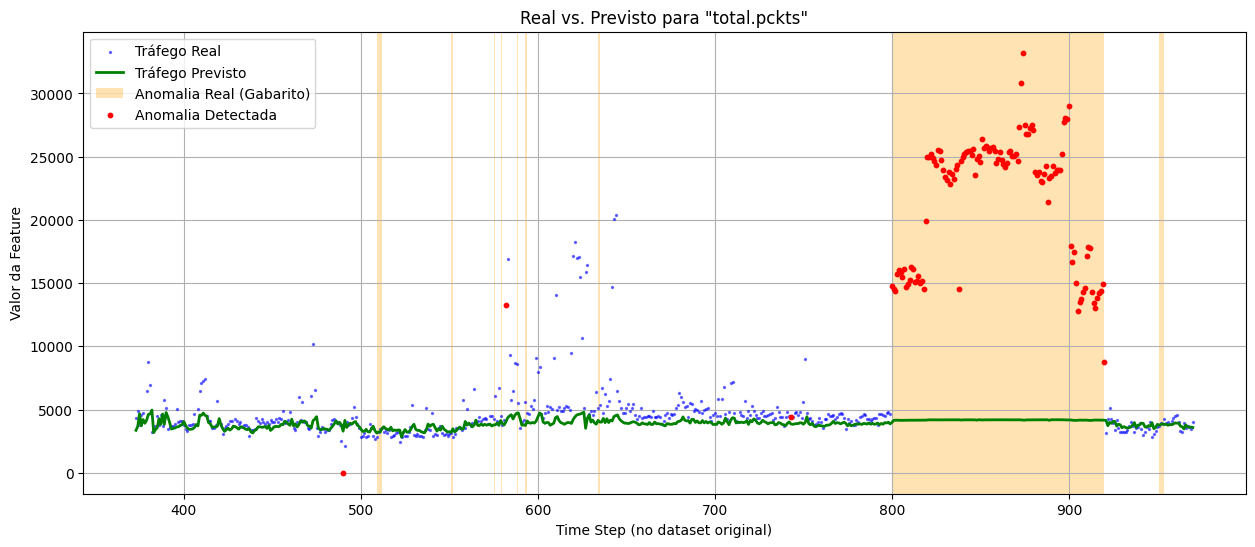

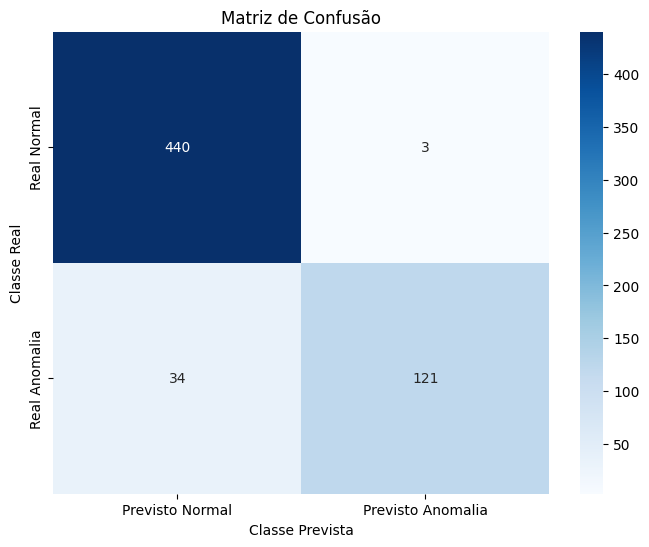



========================= RESUMO DO EXPERIMENTO: CAP 52 =========================
               Dataset  Z-Score Thresh   TP   TN  FP  FN  Acurácia  Precisão Ponderada  Recall Ponderado    Tempo de Predição
0   cap52processed.csv           160.0  121  442   1  34  0.941472            0.944961          0.941472  Antecipação: 4m 48s
1   cap52processed.csv           150.0  121  442   1  34  0.941472            0.944961          0.941472  Antecipação: 4m 48s
2   cap52processed.csv           140.0  121  442   1  34  0.941472            0.944961          0.941472  Antecipação: 4m 48s
3   cap52processed.csv           130.0  121  442   1  34  0.941472            0.944961          0.941472  Antecipação: 4m 48s
4   cap52processed.csv           125.0  121  442   1  34  0.941472            0.944961          0.941472  Antecipação: 4m 48s
5   cap52processed.csv           120.0  121  442   1  34  0.941472            0.944961          0.941472  Antecipação: 4m 48s
6   cap52processed.csv           1

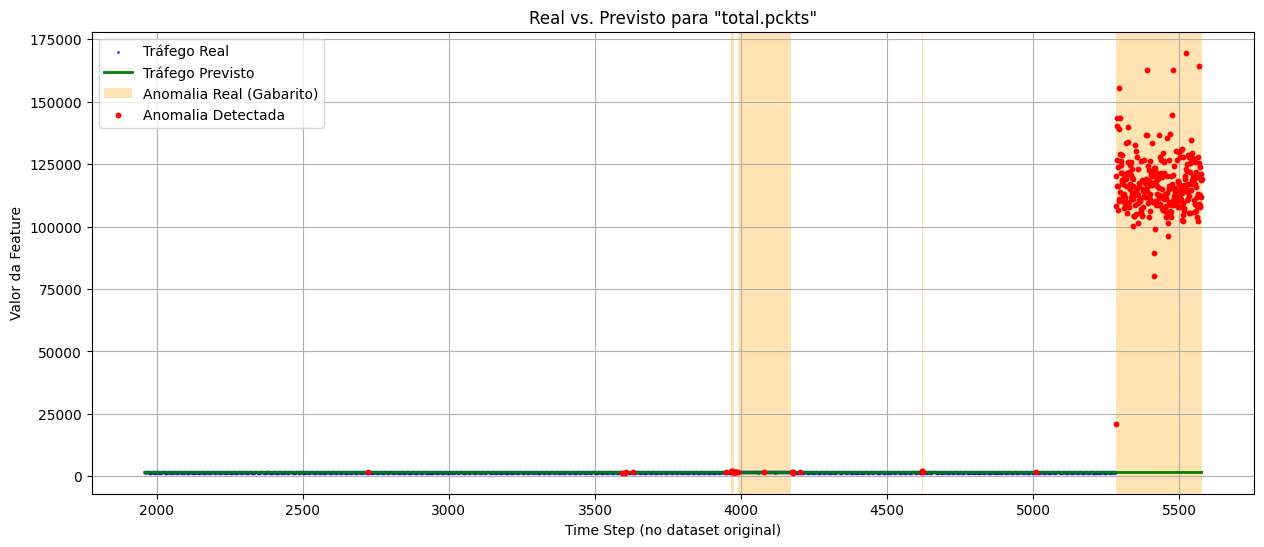

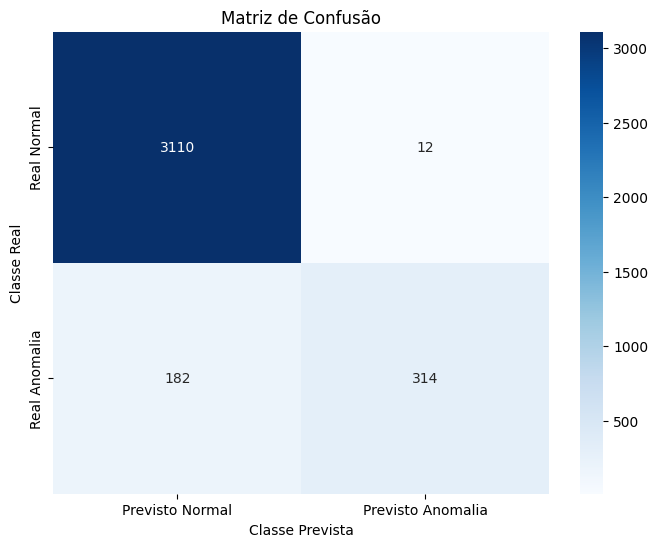


===== AVALIAÇÃO COM Z-SCORE THRESHOLD = 10.00 =====
TP: 326, TN: 3107, FP: 15, FN: 170
Acurácia: 0.9489, Precisão Ponderada: 0.9492, Recall Ponderado: 0.9489


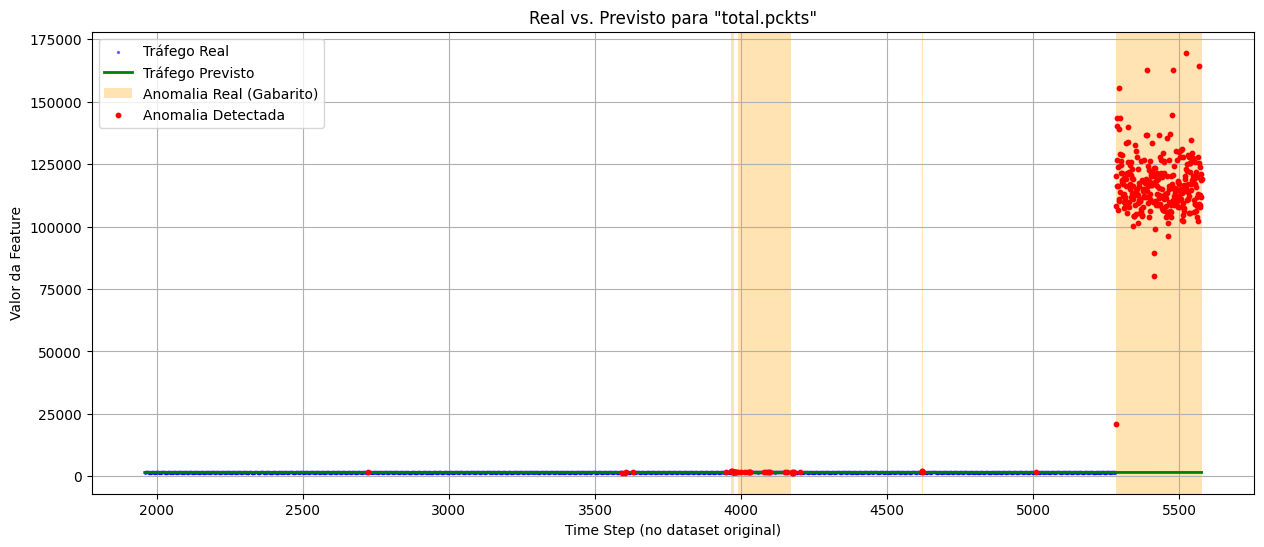

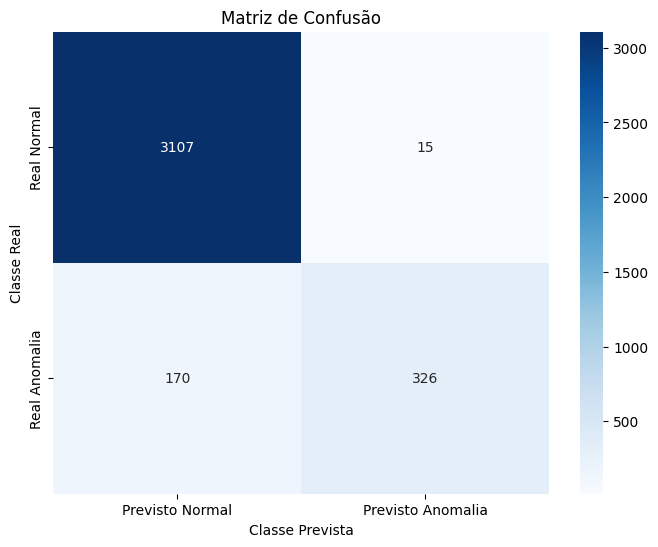


===== AVALIAÇÃO COM Z-SCORE THRESHOLD = 9.00 =====
TP: 478, TN: 3106, FP: 16, FN: 18
Acurácia: 0.9906, Precisão Ponderada: 0.9906, Recall Ponderado: 0.9906


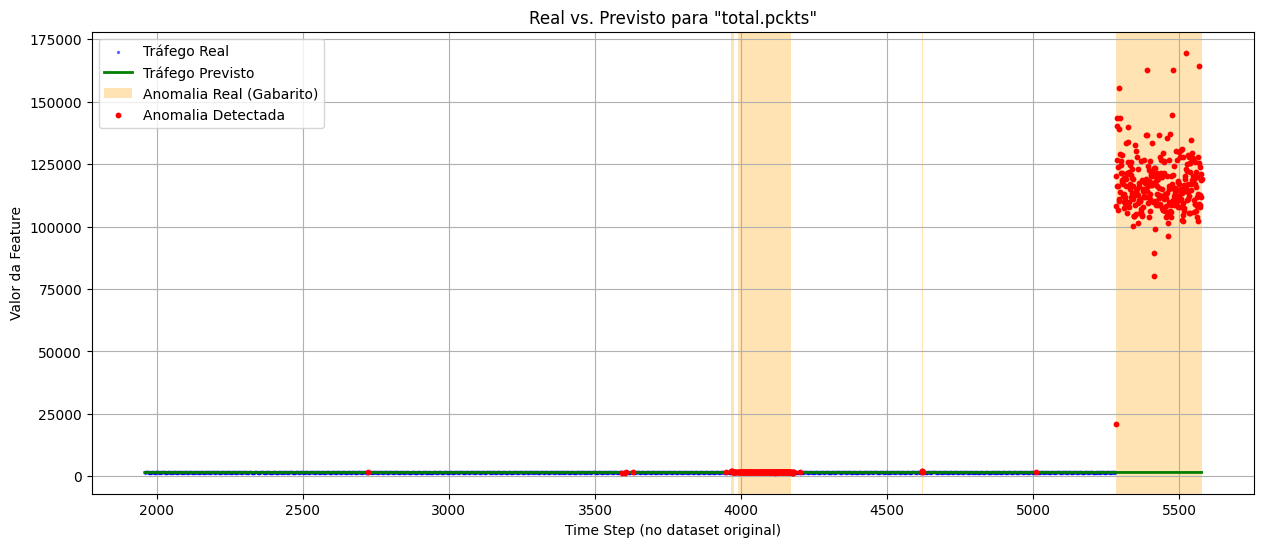

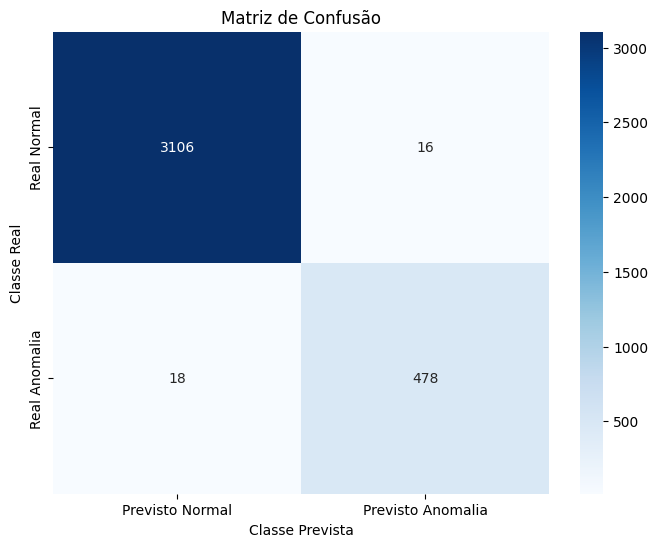


===== AVALIAÇÃO COM Z-SCORE THRESHOLD = 8.50 =====
TP: 493, TN: 3106, FP: 16, FN: 3
Acurácia: 0.9947, Precisão Ponderada: 0.9949, Recall Ponderado: 0.9947


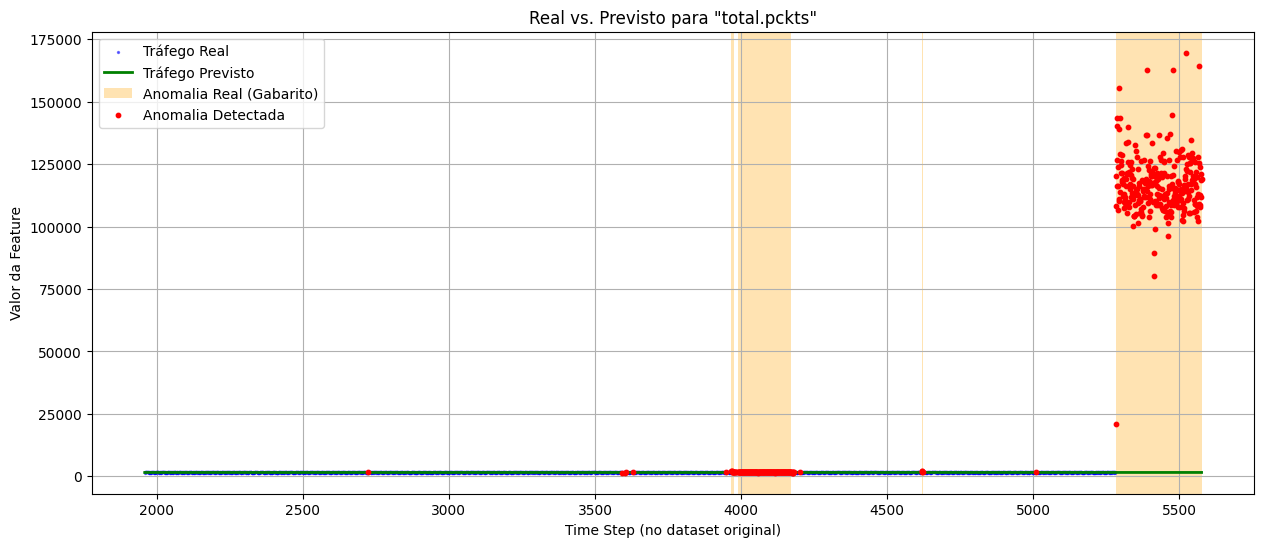

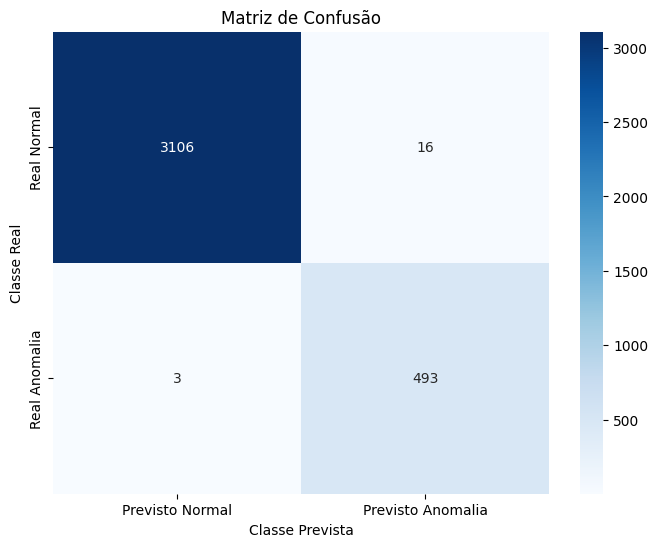


===== AVALIAÇÃO COM Z-SCORE THRESHOLD = 8.00 =====
TP: 494, TN: 3106, FP: 16, FN: 2
Acurácia: 0.9950, Precisão Ponderada: 0.9951, Recall Ponderado: 0.9950


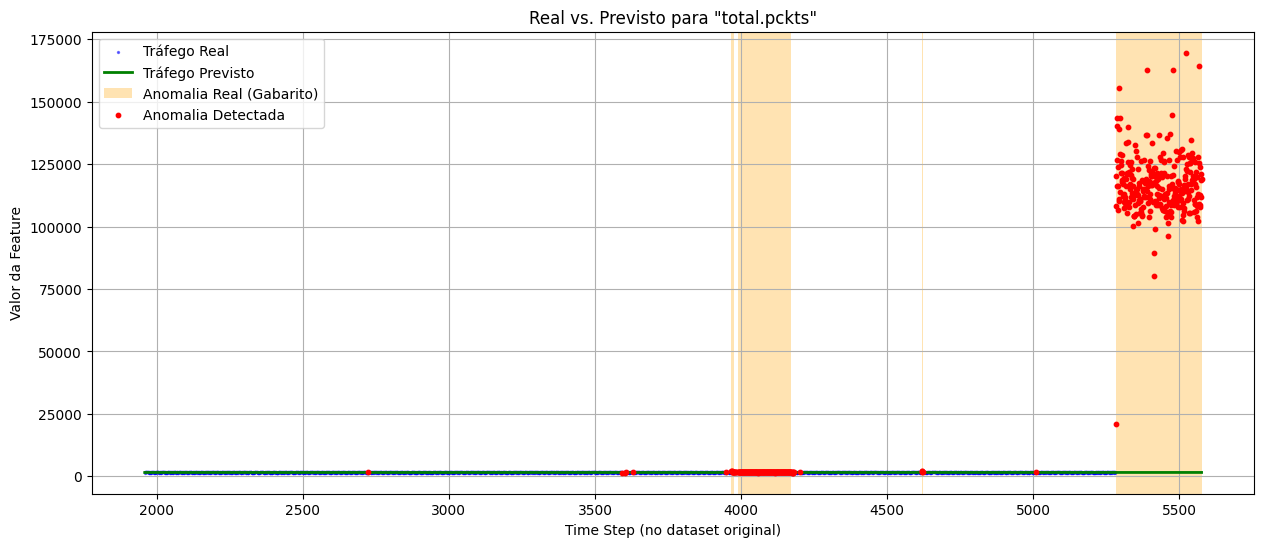

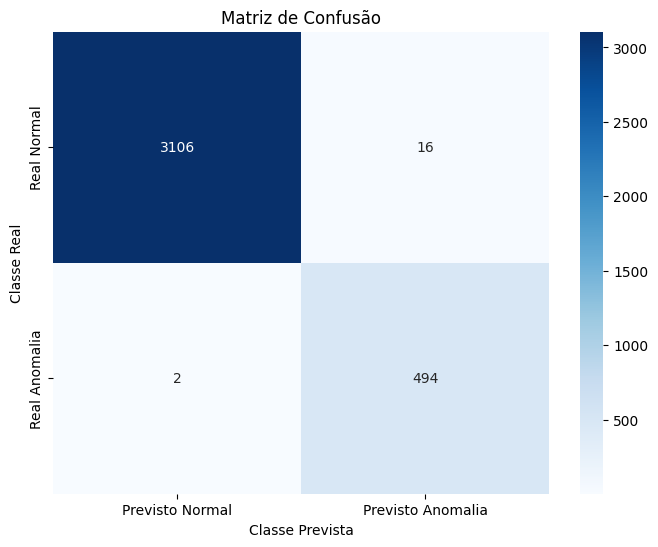


===== AVALIAÇÃO COM Z-SCORE THRESHOLD = 7.50 =====
TP: 496, TN: 3106, FP: 16, FN: 0
Acurácia: 0.9956, Precisão Ponderada: 0.9957, Recall Ponderado: 0.9956


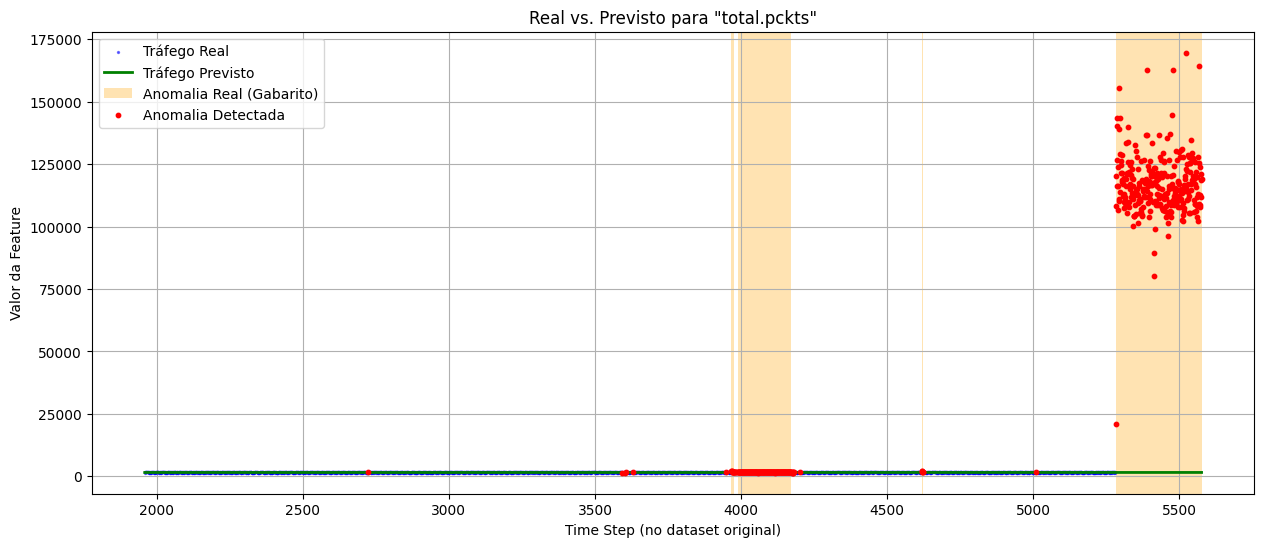

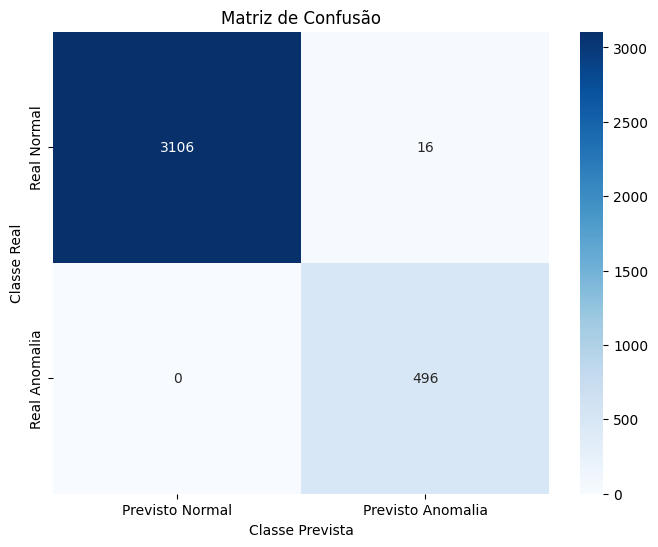


===== AVALIAÇÃO COM Z-SCORE THRESHOLD = 7.00 =====
TP: 496, TN: 3105, FP: 17, FN: 0
Acurácia: 0.9953, Precisão Ponderada: 0.9955, Recall Ponderado: 0.9953


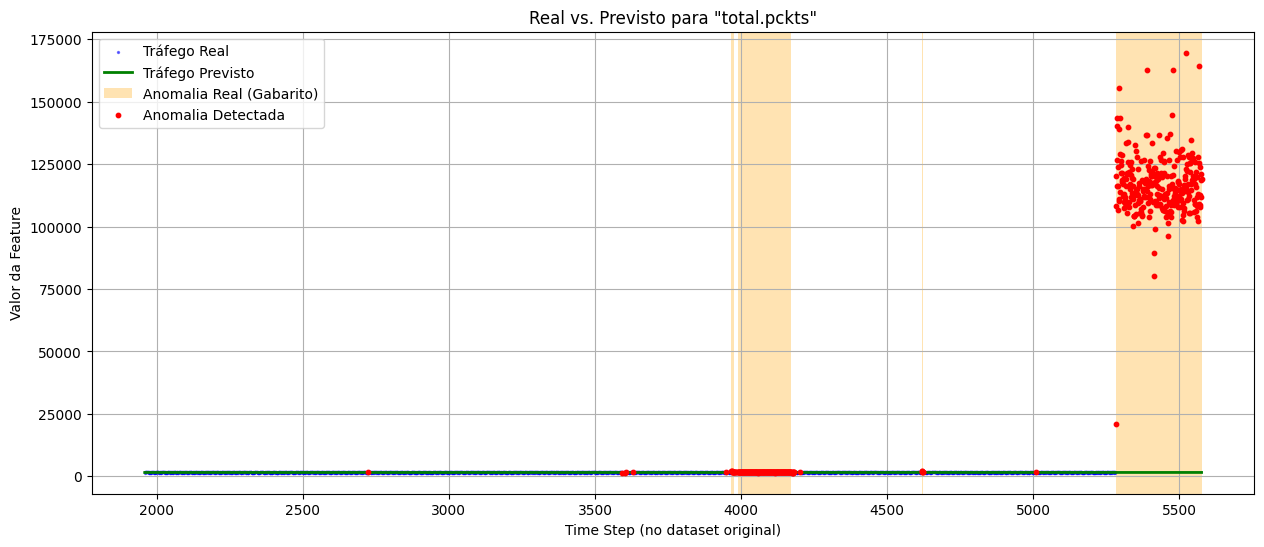

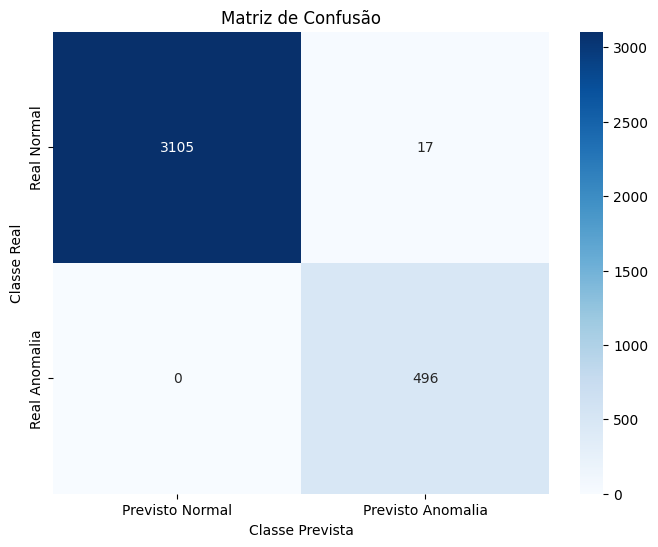


===== AVALIAÇÃO COM Z-SCORE THRESHOLD = 6.50 =====
TP: 496, TN: 3105, FP: 17, FN: 0
Acurácia: 0.9953, Precisão Ponderada: 0.9955, Recall Ponderado: 0.9953


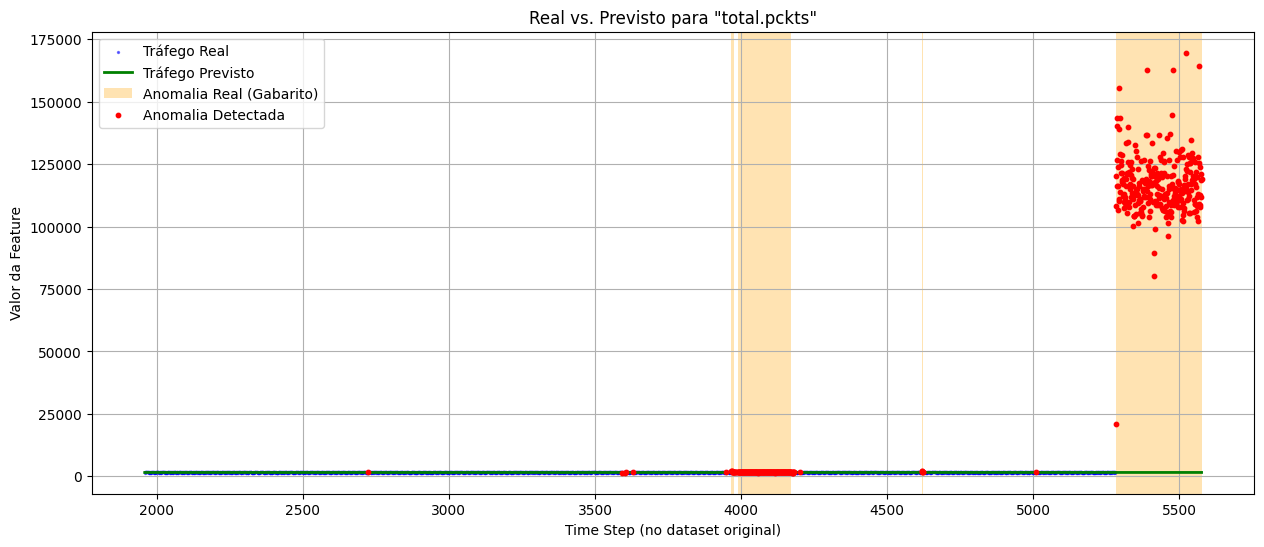

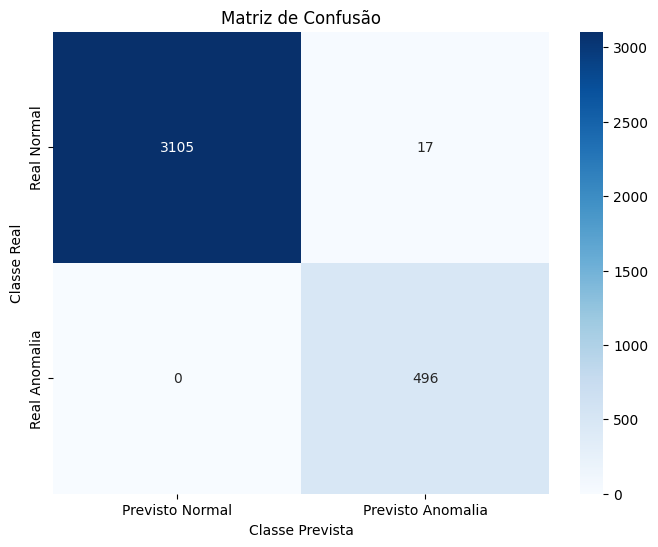


===== AVALIAÇÃO COM Z-SCORE THRESHOLD = 5.00 =====
TP: 496, TN: 3102, FP: 20, FN: 0
Acurácia: 0.9945, Precisão Ponderada: 0.9947, Recall Ponderado: 0.9945


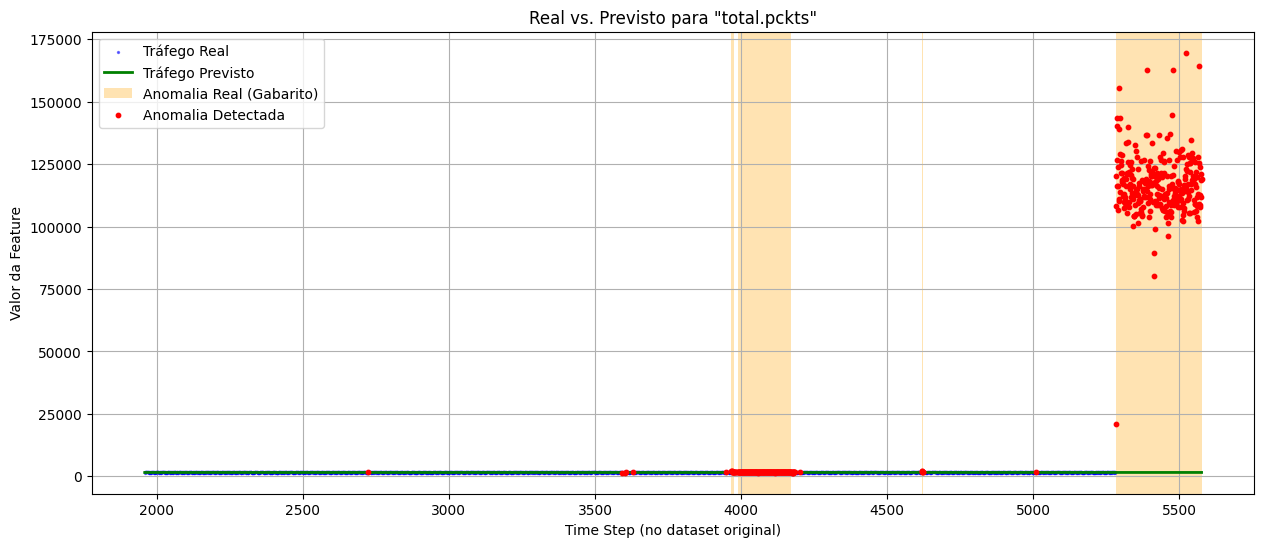

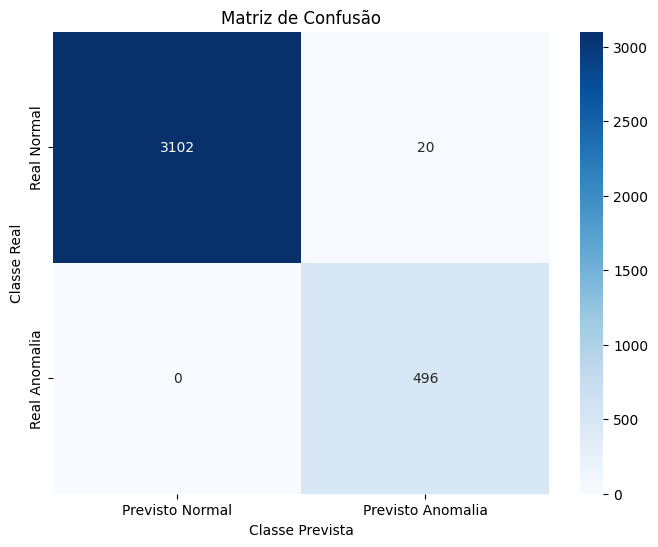


===== AVALIAÇÃO COM Z-SCORE THRESHOLD = 3.00 =====
TP: 496, TN: 3098, FP: 24, FN: 0
Acurácia: 0.9934, Precisão Ponderada: 0.9937, Recall Ponderado: 0.9934


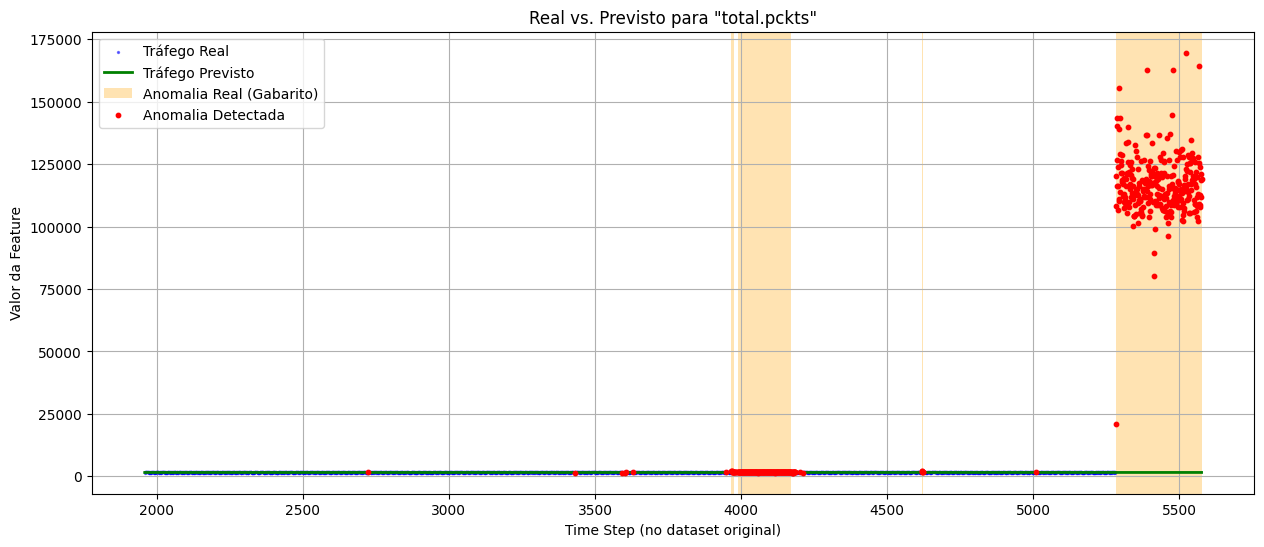

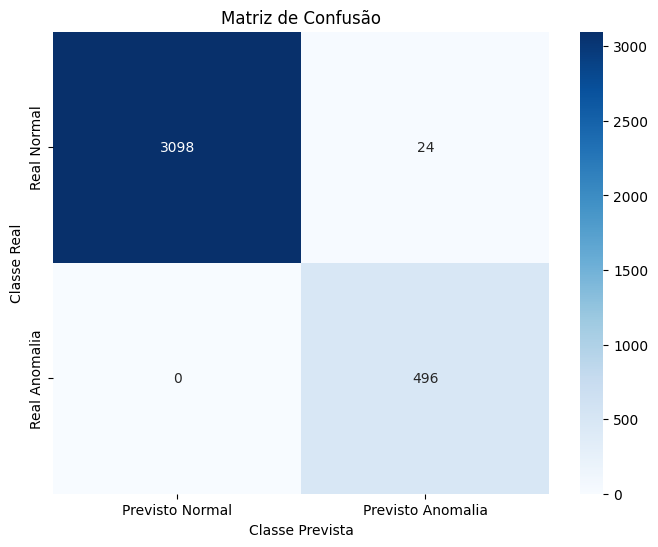



========================= RESUMO DO EXPERIMENTO: MENTORED =========================
        Dataset  Z-Score Thresh   TP    TN  FP   FN  Acurácia  Precisão Ponderada  Recall Ponderado     Tempo de Predição
0  mentored.csv            15.0  314  3110  12  182  0.946379            0.947247          0.946379  Antecipação: 14m 39s
1  mentored.csv            10.0  326  3107  15  170  0.948867            0.949205          0.948867  Antecipação: 14m 39s
2  mentored.csv             9.0  478  3106  16   18  0.990603            0.990588          0.990603  Antecipação: 14m 39s
3  mentored.csv             8.5  493  3106  16    3  0.994748            0.994858          0.994748  Antecipação: 14m 39s
4  mentored.csv             8.0  494  3106  16    2  0.995025            0.995144          0.995025  Antecipação: 14m 39s
5  mentored.csv             7.5  496  3106  16    0  0.995578            0.995716          0.995578  Antecipação: 14m 39s
6  mentored.csv             7.0  496  3105  17    0  0.99530

In [9]:
if __name__ == '__main__':
    for exp_config in EXPERIMENTS_CONFIG:
        exp_name = exp_config["name"]
        print(f"\n\n{'='*20} INICIANDO EXPERIMENTO: {exp_name.upper()} {'='*20}")

        current_csv_file = exp_config["csv_file"]
        current_model_path = f"mamba_detector_{exp_name}.pth"
        current_params_path = f"best_params_{exp_name}.json"

        try:
            temp_df = pd.read_csv(current_csv_file, on_bad_lines='skip', nrows=1, low_memory=False)
            temp_df.columns = temp_df.columns.str.strip()
            
            TARGET_COLUMN = None
            temp_df_lower_cols = [c.lower() for c in temp_df.columns]

            if 'label' in temp_df_lower_cols:
                TARGET_COLUMN = temp_df.columns[temp_df_lower_cols.index('label')]
            elif 'has_bot' in temp_df_lower_cols:
                TARGET_COLUMN = temp_df.columns[temp_df_lower_cols.index('has_bot')]
            else:
                TARGET_COLUMN = 'label'

            print(f"Coluna de anomalia identificada/definida como: '{TARGET_COLUMN}'")
            
            INITIAL_FEATURE_COLS = [col for col in temp_df.columns if col.lower() not in ['label', 'has_bot', 'unnamed: 0']]

        except FileNotFoundError:
            print(f"ERRO: Arquivo '{current_csv_file}' não encontrado. Pulando.")
            continue
        
        data_args = {
            "file_path": current_csv_file, 
            "feature_cols": list(INITIAL_FEATURE_COLS), 
            "label_col": TARGET_COLUMN,
            "train_start_index": exp_config.get("train_start_index", 0),
            "train_end_index": exp_config["train_end_index"],
        }

        if os.path.exists(current_model_path) and os.path.exists(current_params_path):
            print(f"--- Carregando modelo e parâmetros existentes ---")
            with open(current_params_path, 'r') as f: best_params = json.load(f)
            
            # LINHA CORRIGIDA AQUI
            # Nós adicionamos **data_args para passar todos os argumentos necessários
            data, scaler, original_test_df, final_feature_cols = load_and_prepare_data_by_index(
                seq_length=best_params['sequence_length'], **data_args
            )
            
            if data is None or not data[0].size:
                print(f"Erro ao carregar dados para o experimento '{exp_name}'. Pulando.")
                continue

            trained_final_model = MambaAnomalyDetector(
                input_dim=data[0].shape[2], d_model=best_params['d_model'], d_state=best_params['d_state'],
                num_layers=best_params['num_layers'], dropout_rate=best_params.get('dropout_rate', 0.1)
            )
            trained_final_model.load_state_dict(torch.load(current_model_path))
        else:
            print(f"--- Modelo não encontrado. Iniciando otimização ---")
            study = optuna.create_study(direction='minimize')
            study.optimize(lambda trial: objective(trial, exp_config, INITIAL_FEATURE_COLS), n_trials=exp_config["optuna_trials"])
            
            best_params = study.best_params
            print(f"\nOtimização concluída. Menor perda: {study.best_value:.4f}")
            print(f"Melhores parâmetros: {best_params}")
            with open(current_params_path, 'w') as f: json.dump(best_params, f)

            print("\n--- Treinando modelo final com os melhores parâmetros ---")
            data, scaler, original_test_df, final_feature_cols = load_and_prepare_data_by_index(
                seq_length=best_params['sequence_length'], **data_args
            )
            
            if data is None or not data[0].size:
                print(f"Erro ao carregar dados após otimização para o experimento '{exp_name}'. Pulando.")
                continue

            final_model = MambaAnomalyDetector(
                input_dim=data[0].shape[2], d_model=best_params['d_model'], d_state=best_params['d_state'],
                num_layers=best_params['num_layers'], dropout_rate=best_params['dropout_rate']
            )
            train_loader = DataLoader(TensorDataset(torch.from_numpy(data[0]), torch.from_numpy(data[1])), batch_size=best_params['batch_size'], shuffle=True)
            
            trained_final_model = train_model(
                model=final_model, train_loader=train_loader, epochs=best_params['epochs'],
                learning_rate=best_params['learning_rate'], weight_decay=best_params['weight_decay'],
                max_grad_norm=best_params['max_grad_norm'], verbose=True
            )
            torch.save(trained_final_model.state_dict(), current_model_path)
            print(f"Modelo treinado salvo em '{current_model_path}'")

        if data:
            experiment_results = []
            print("\n--- Avaliando o modelo final ---")
            scaler.source_file_path_ = current_csv_file
            
            adjusted_anomaly_start = exp_config["anomaly_start_index"]
            if exp_config.get("resample_to_minutes", False):
                adjusted_anomaly_start //= 60

            for z in sorted(list(set(exp_config.get("z_scores_to_test"))), reverse=True):
                results = evaluate_model(
                    model=trained_final_model, data_tuple=data, scaler=scaler,
                    original_test_df=original_test_df, best_params=best_params,
                    anomaly_start_index=adjusted_anomaly_start,
                    current_feature_cols=final_feature_cols, z_score_threshold=z,
                    feature_to_plot=exp_config.get("plot_feature", "total.pckts"),
                    show_plots=True
                )
                if results: experiment_results.append(results)

            if experiment_results:
                print(f"\n\n" + "="*25 + f" RESUMO DO EXPERIMENTO: {exp_name.upper()} " + "="*25)
                results_df = pd.DataFrame(experiment_results)
                # Atualizando a ordem das colunas para a nova estrutura de resultados
                column_order = ['Dataset', 'Z-Score Thresh', 'TP', 'TN', 'FP', 'FN', 'Acurácia', 'Precisão Ponderada', 'Recall Ponderado', 'Tempo de Predição']
                final_columns = [col for col in column_order if col in results_df.columns]
                print(results_df[final_columns].to_string())

            print(f"\n{'='*20} EXPERIMENTO {exp_name.upper()} CONCLUÍDO {'='*20}")
        else:
            print(f"Não foi possível carregar ou processar dados para o experimento '{exp_name}'.")
